[View in Colaboratory](https://colab.research.google.com/github/mgyong/examples/blob/master/Q_Learning_CartPole_Exercise_(solution).ipynb)

# Q-Learning CartPole Exercise (solution)

go/rl-exercise-qlearning-solution

Last updated 18 Aug 2017

Author: Ethan Holly (eholly@)

Thanks Charles Weill (weill@) for implementing environment visualization in colab!

In this exercise, you will experiment with a Q-Learning RL algorithm and environment.

The environment is CartPole: from OpenAI Gym https://gym.openai.com/envs/CartPole-v0

## Setup

On your corp machine, run this colab kernel. If you want to render full episodes, you will need to run this directly from your physical machine. If you only want to train and plot performance, you can run this through an ssh connection:
  - /google/data/ro/users/eh/eholly/www/gym_notebook.par

If on laptop, create ssh tunnel to your_corp_machine:8888 :
  - https://g3doc.corp.google.com/company/teams/colab/gettingstarted/index.md?cl=head#remote-access-to-local-runtimes-using-ssh-port-forwarding
  - $ ssh <your_corp_machine> -L 8888:localhost:8888

Click CONNECT on this Colab page and connect to local runtime at port 8888.

Skim through the following code blocks to gain an idea of how they work, run the training block to observe the experiment, and consider the questions below.

In [0]:
# @title (Run This) Imports
import os
import gym
import sys
from gym import spaces
import numpy as np
import pyglet
pyglet.options['search_local_libs']=False
pyglet.options['shadow_window']=False
from pyglet.window import xlib
xlib._have_utf8 = False
import pyglet.window
import tensorflow as tf
from google3.third_party.tensorflow.contrib import slim

In [0]:
# @title (Run This) Visualization Source Code
# Source: https://github.com/jakevdp/JSAnimation
import os
import sys
import random
import string
import warnings
if sys.version_info < (3, 0):
    from cStringIO import StringIO as InMemory
else:
    from io import BytesIO as InMemory
from matplotlib.animation import writers, FileMovieWriter
from base64 import b64encode


JS_INCLUDE = """
<script language="javascript">
  /* Define the Animation class */
  function Animation(frames, img_id, slider_id, interval, loop_select_id){
    this.img_id = img_id;
    this.slider_id = slider_id;
    this.loop_select_id = loop_select_id;
    this.interval = interval;
    this.current_frame = 0;
    this.direction = 0;
    this.timer = null;
    this.frames = new Array(frames.length);

    for (var i=0; i<frames.length; i++)
    {
     this.frames[i] = new Image();
     this.frames[i].src = frames[i];
    }
    document.getElementById(this.slider_id).max = this.frames.length - 1;
    this.set_frame(this.current_frame);
  }

  Animation.prototype.get_loop_state = function(){
    var button_group = document[this.loop_select_id].state;
    for (var i = 0; i < button_group.length; i++) {
        var button = button_group[i];
        if (button.checked) {
            return button.value;
        }
    }
    return undefined;
  }

  Animation.prototype.set_frame = function(frame){
    this.current_frame = frame;
    document.getElementById(this.img_id).src = this.frames[this.current_frame].src;
    document.getElementById(this.slider_id).value = this.current_frame;
  }

  Animation.prototype.next_frame = function()
  {
    this.set_frame(Math.min(this.frames.length - 1, this.current_frame + 1));
  }

  Animation.prototype.previous_frame = function()
  {
    this.set_frame(Math.max(0, this.current_frame - 1));
  }

  Animation.prototype.first_frame = function()
  {
    this.set_frame(0);
  }

  Animation.prototype.last_frame = function()
  {
    this.set_frame(this.frames.length - 1);
  }

  Animation.prototype.slower = function()
  {
    this.interval /= 0.7;
    if(this.direction > 0){this.play_animation();}
    else if(this.direction < 0){this.reverse_animation();}
  }

  Animation.prototype.faster = function()
  {
    this.interval *= 0.7;
    if(this.direction > 0){this.play_animation();}
    else if(this.direction < 0){this.reverse_animation();}
  }

  Animation.prototype.anim_step_forward = function()
  {
    this.current_frame += 1;
    if(this.current_frame < this.frames.length){
      this.set_frame(this.current_frame);
    }else{
      var loop_state = this.get_loop_state();
      if(loop_state == "loop"){
        this.first_frame();
      }else if(loop_state == "reflect"){
        this.last_frame();
        this.reverse_animation();
      }else{
        this.pause_animation();
        this.last_frame();
      }
    }
  }

  Animation.prototype.anim_step_reverse = function()
  {
    this.current_frame -= 1;
    if(this.current_frame >= 0){
      this.set_frame(this.current_frame);
    }else{
      var loop_state = this.get_loop_state();
      if(loop_state == "loop"){
        this.last_frame();
      }else if(loop_state == "reflect"){
        this.first_frame();
        this.play_animation();
      }else{
        this.pause_animation();
        this.first_frame();
      }
    }
  }

  Animation.prototype.pause_animation = function()
  {
    this.direction = 0;
    if (this.timer){
      clearInterval(this.timer);
      this.timer = null;
    }
  }

  Animation.prototype.play_animation = function()
  {
    this.pause_animation();
    this.direction = 1;
    var t = this;
    if (!this.timer) this.timer = setInterval(function(){t.anim_step_forward();}, this.interval);
  }

  Animation.prototype.reverse_animation = function()
  {
    this.pause_animation();
    this.direction = -1;
    var t = this;
    if (!this.timer) this.timer = setInterval(function(){t.anim_step_reverse();}, this.interval);
  }
</script>
"""


DISPLAY_TEMPLATE = """
<div class="animation" align="center">
    <img id="_anim_img{id}">
    <br>
    <input id="_anim_slider{id}" type="range" style="width:350px" name="points" min="0" max="1" step="1" value="0" onchange="anim{id}.set_frame(parseInt(this.value));"></input>
    <br>
    <button onclick="anim{id}.slower()">&#8211;</button>
    <button onclick="anim{id}.first_frame()"><img class="anim_icon" src="https://github.com/jakevdp/JSAnimation/blob/master/JSAnimation/icons/first.png?raw=true"></button>
    <button onclick="anim{id}.previous_frame()"><img class="anim_icon" src="https://github.com/jakevdp/JSAnimation/blob/master/JSAnimation/icons/prev.png?raw=true"></button>
    <button onclick="anim{id}.reverse_animation()"><img class="anim_icon" src="https://github.com/jakevdp/JSAnimation/blob/master/JSAnimation/icons/reverse.png?raw=true"></button>
    <button onclick="anim{id}.pause_animation()"><img class="anim_icon" src="https://github.com/jakevdp/JSAnimation/blob/master/JSAnimation/icons/pause.png?raw=true"></button>
    <button onclick="anim{id}.play_animation()"><img class="anim_icon" src="https://github.com/jakevdp/JSAnimation/blob/master/JSAnimation/icons/play.png?raw=true"></button>
    <button onclick="anim{id}.next_frame()"><img class="anim_icon" src="https://github.com/jakevdp/JSAnimation/blob/master/JSAnimation/icons/next.png?raw=true"></button>
    <button onclick="anim{id}.last_frame()"><img class="anim_icon" src="https://github.com/jakevdp/JSAnimation/blob/master/JSAnimation/icons/last.png?raw=true"></button>
    <button onclick="anim{id}.faster()">+</button>
  <form action="#n" name="_anim_loop_select{id}" class="anim_control">
    <input type="radio" name="state" value="once" {once_checked}> Once </input>
    <input type="radio" name="state" value="loop" {loop_checked}> Loop </input>
    <input type="radio" name="state" value="reflect" {reflect_checked}> Reflect </input>
  </form>
</div>


<script language="javascript">
  /* Instantiate the Animation class. */
  /* The IDs given should match those used in the template above. */
  (function() {{
    var img_id = "_anim_img{id}";
    var slider_id = "_anim_slider{id}";
    var loop_select_id = "_anim_loop_select{id}";
    var frames = new Array({Nframes});
    {fill_frames}

    /* set a timeout to make sure all the above elements are created before
       the object is initialized. */
    setTimeout(function() {{
        anim{id} = new Animation(frames, img_id, slider_id, {interval}, loop_select_id);
    }}, 0);
  }})()
</script>
"""

INCLUDED_FRAMES = """
  for (var i=0; i<{Nframes}; i++){{
    frames[i] = "{frame_dir}/frame" + ("0000000" + i).slice(-7) + ".{frame_format}";
  }}
"""


def _included_frames(frame_list, frame_format):
    """frame_list should be a list of filenames"""
    return INCLUDED_FRAMES.format(Nframes=len(frame_list),
                                  frame_dir=os.path.dirname(frame_list[0]),
                                  frame_format=frame_format)


def _embedded_frames(frame_list, frame_format):
    """frame_list should be a list of base64-encoded png files"""
    template = '  frames[{0}] = "data:image/{1};base64,{2}"\n'
    embedded = "\n"
    for i, frame_data in enumerate(frame_list):
        embedded += template.format(i, frame_format,
                                    frame_data.replace('\n', '\\\n'))
    return embedded


@writers.register('html')
class HTMLWriter(FileMovieWriter):
    # we start the animation id count at a random number: this way, if two
    # animations are meant to be included on one HTML page, there is a
    # very small chance of conflict.
    rng = random.Random()
    exec_key = 'animation.ffmpeg_path'
    args_key = 'animation.ffmpeg_args'
    supported_formats = ['png', 'jpeg', 'tiff', 'svg']

    @classmethod
    def new_id(cls):
        #return '%16x' % cls.rng.getrandbits(64)
        return ''.join(cls.rng.choice(string.ascii_uppercase)
                       for x in range(16))

    def __init__(self, fps=30, codec=None, bitrate=None, extra_args=None,
                 metadata=None, embed_frames=False, default_mode='loop'):
        self.embed_frames = embed_frames
        self.default_mode = default_mode.lower()

        if self.default_mode not in ['loop', 'once', 'reflect']:
            self.default_mode = 'loop'
            warnings.warn("unrecognized default_mode: using 'loop'")

        self._saved_frames = list()
        super(HTMLWriter, self).__init__(fps, codec, bitrate,
                                         extra_args, metadata)

    def setup(self, fig, outfile, dpi, frame_dir=None):
        if os.path.splitext(outfile)[-1] not in ['.html', '.htm']:
            raise ValueError("outfile must be *.htm or *.html")

        if not self.embed_frames:
            if frame_dir is None:
                frame_dir = outfile.rstrip('.html') + '_frames'
            if not os.path.exists(frame_dir):
                os.makedirs(frame_dir)
            frame_prefix = os.path.join(frame_dir, 'frame')
        else:
            frame_prefix = None

        super(HTMLWriter, self).setup(fig, outfile, dpi,
                                      frame_prefix, clear_temp=False)

    def grab_frame(self, **savefig_kwargs):
        if self.embed_frames:
            suffix = '.' + self.frame_format
            f = InMemory()
            self.fig.savefig(f, format=self.frame_format,
                             dpi=self.dpi, **savefig_kwargs)
            f.seek(0)
            self._saved_frames.append(b64encode(f.read()).decode('ascii'))
        else:
            return super(HTMLWriter, self).grab_frame(**savefig_kwargs)

    def _run(self):
        # make a ducktyped subprocess standin
        # this is called by the MovieWriter base class, but not used here.
        class ProcessStandin(object):
            returncode = 0
            def communicate(self):
                return ('', '')
        self._proc = ProcessStandin()

        # save the frames to an html file
        if self.embed_frames:
            fill_frames = _embedded_frames(self._saved_frames,
                                           self.frame_format)
        else:
            # temp names is filled by FileMovieWriter
            fill_frames = _included_frames(self._temp_names,
                                           self.frame_format)

        mode_dict = dict(once_checked='',
                         loop_checked='',
                         reflect_checked='')
        mode_dict[self.default_mode + '_checked'] = 'checked'

        interval = int(1000. / self.fps)

        with open(self.outfile, 'w') as of:
            of.write(JS_INCLUDE)
            of.write(DISPLAY_TEMPLATE.format(id=self.new_id(),
                                             Nframes=len(self._temp_names),
                                             fill_frames=fill_frames,
                                             interval=interval,
                                             **mode_dict))
            
  # from .html_writer import HTMLWriter
from matplotlib.animation import Animation
import matplotlib.pyplot as plt
import tempfile
import random
import os


__all__ = ['anim_to_html', 'display_animation']


class _NameOnlyTemporaryFile(object):
    """A context-managed temporary file which is not opened.

    The file should be accessible by name on any system.

    Parameters
    ----------
    suffix : string
        The suffix of the temporary file (default = '')
    prefix : string
        The prefix of the temporary file (default = '_tmp_')
    hash_length : string
        The length of the random hash.  The size of the hash space will
        be 16 ** hash_length (default=8)
    seed : integer
        the seed for the random number generator.  If not specified, the
        system time will be used as a seed.
    absolute : boolean
        If true, return an absolute path to a temporary file in the current
        working directory.

    Example
    -------

    >>> with _NameOnlyTemporaryFile(seed=0, absolute=False) as f:
    ...     print(f)
    ...
    _tmp_d82c07cd
    >>> os.path.exists('_tmp_d82c07cd')  # file removed after context
    False

    """
    def __init__(self, prefix='_tmp_', suffix='', hash_length=8,
                 seed=None, absolute=True):
        rng = random.Random(seed)
        self.name = '%s%0*x%s' % (prefix, hash_length,
                                  rng.getrandbits(4 * hash_length), suffix)
        if absolute:
            self.name = os.path.abspath(self.name)

    def __enter__(self):
        return self

    def __exit__(self, *exc_info):
        if os.path.exists(self.name):
            os.remove(self.name)


def anim_to_html(anim, fps=None, embed_frames=True, default_mode='loop'):
    """Generate HTML representation of the animation"""
    if fps is None and hasattr(anim, '_interval'):
        # Convert interval in ms to frames per second
        fps = 1000. / anim._interval

    plt.close(anim._fig)
    if hasattr(anim, "_html_representation"):
        return anim._html_representation
    else:
        # tempfile can't be used here: we need a filename, and this
        # fails on windows.  Instead, we use a custom filename generator
        #with tempfile.NamedTemporaryFile(suffix='.html') as f:
        with _NameOnlyTemporaryFile(suffix='.html') as f:
            anim.save(f.name,  writer=HTMLWriter(fps=fps,
                                                 embed_frames=embed_frames,
                                                 default_mode=default_mode))
            html = open(f.name).read()

        anim._html_representation = html
        return html


def display_animation(anim, **kwargs):
    """Display the animation with an IPython HTML object"""
    from IPython.display import HTML
    return HTML(anim_to_html(anim, **kwargs))


# This is the magic that makes animations display automatically in the
# IPython notebook.  The _repr_html_ method is a special method recognized
# by IPython.
Animation._repr_html_ = anim_to_html

%matplotlib inline
# from JSAnimation.IPython_display import display_animation
import matplotlib.pyplot as plt
from IPython.display import display
from matplotlib import animation

def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))



## QNet

This class implements a neural network that predicts Q-values for each action.

It takes observations as input and outputs a vector of Q-values, each index corresponding to one action.

The parameters of this neural net will be trained below using the DQN learning algorithm.

In [0]:
class QNet:
  """Simple discrete-action policy with feed-forward net."""
  
  @staticmethod
  def make_target_net(qnet):
    """Makes a clone of the given qnet, but uses the scope 'target_net'."""
    return QNet(qnet._obs_dim,
                qnet._action_dim,
                qnet._epsilon,
                'target_' + qnet._scope)
  
  def __init__(self,
               obs_dim,
               action_dim,
               epsilon=0.1,
               scope='qnet'):
    """Create a QNet.
    
    Args:
      obs_dim: The dimension of the observation vector.
      action_dim: The number of discrete actions possible.
      epsilon: The default probability of taking a random action, instead of the
        action predicted to have the highest value.
      scope: Name for tf.variable_scope for params.
    """
    self._obs_dim = obs_dim
    self._action_dim = action_dim
    self._epsilon = epsilon
    self._scope = scope
    self._make_net()
  
  def _make_net(self):
    # Make observation placeholder with batch dimension.
    with tf.variable_scope(self._scope):
      self._obs_placeholder = tf.placeholder(dtype=tf.float32, 
                                             shape=[None, self._obs_dim])
      self._hidden = slim.fully_connected(self._obs_placeholder,
                                           100,
                                           activation_fn=tf.nn.relu,
                                           scope='hidden')
      self._action_values = slim.fully_connected(self._hidden,
                                                 self._action_dim,
                                                 activation_fn=tf.identity,
                                                 scope='logits')
      
    # Set up references to variables for getting & setting params.
    self._variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=self._scope)
    self._var_placeholders = []
    self._var_assigns = []
    for var in self._variables:
      var_ph = tf.placeholder(dtype=tf.float32, shape=var.shape)
      self._var_placeholders.append(var_ph)
      self._var_assigns.append(var.assign(var_ph))
    
  @property
  def variables(self):
    """Property returns a list of tf.Variable that parameterize the QNet."""
    return self._variables
    
  @property
  def action_dim(self):
    """The action dim of this QNet."""
    return self._action_dim
  
  @property
  def obs_placeholder(self):
    """Property returns observation placeholder. shape=[batch_dim, obs_dim]"""
    return self._obs_placeholder
  
  @property
  def action_values(self):
    """Returns tensor of action values. shape=[batch_dim, action_dim]"""
    return self._action_values
  
  def get_params(self, sess=None):
    """Return the parameter vals as an array of tensors, one for each param."""
    sess = sess or tf.get_default_session()
    return sess.run(self._variables)
  
  def set_params(self, param_vals, sess=None):
    """Sets policy variables equal to param_vals"""
    sess = sess or tf.get_default_session()
    return sess.run(self._var_assigns,
                    feed_dict={var_ph: param_val
                               for (var_ph, param_val)
                               in zip(self._var_placeholders, param_vals)})
  
  def sample_action(self, obs, epsilon=None, sess=None):
    """Samples an action from the QNet given observation.
    
    Args:
      obs: Vector of observation values.
      epsilon: Random action probability. If not specified, uses self._epsilon,
        which defaults to 0.1.
      sess: The session to use for execution. If not specified, uses
        tf.get_default_session().
    """
    epsilon = epsilon or self._epsilon
    
    # Sample a random action with epsilon probability.
    if np.random.random_sample() < self._epsilon:
      return np.random.randint(0, self._action_dim)
    
    sess = sess or tf.get_default_session()
    action_values = sess.run(self._action_values,
                             feed_dict={self._obs_placeholder: [obs]})
    best_actions = np.argmax(action_values, axis=1)
    return best_actions[0] # remove batch index

## ReplayBuffer

The replay buffer is the dynamic dataset for qlearning.

It gets transitions (observation_t, action_t, reward_t, observation_tp1, pcontinue) and stores them for sampling minibatches.
* observation_t: The observation seen at time t.
* action_t: The action taken at time t.
* reward_t: The reward recieved after taking action_t.
* observation_tp1: The observation at time t+1.
* pcontinue: Float value 1.0 if episode continues after action_t, 0.0 if episode ends after action_t.

Can take a minibatch of transitions from randomly shuffled history.


In [0]:
class ReplayBuffer:
  
  def __init__(self,
               obs_dim,
               action_dim,
               size=1e5,):
    self._obs_dim = obs_dim
    self._action_dim = action_dim
    self._size = size
    
    observations = np.zeros(shape=[size, obs_dim])
    actions = np.zeros(shape=[size, action_dim])
    rewards = np.zeros(shape=[size])
    observations_tp1 = np.zeros_like(observations)
    pcontinues = np.zeros_like(rewards)
    
    # The replay buffer will store its data in 5 numpy arrays, with each index
    #   corresponding to a single environment tranistion.
    self._data = (observations, actions, rewards, observations_tp1, pcontinues)
    
    self._write_index = -1
    self._n = 0
    
  def sample_minibatch(self, batch_size=32):
    """Samples a minibatch of transitions from the replay buffer.
    
    Args:
      batch_size: The number of transitions to pull in the batch.
    
    Returns:
      A tuple of (observations, actions, rewards, observations_tp1, pcontinues).
    """
    if self._n < batch_size:
      raise IndexError('Buffer does not have batch_size=%d transitions yet.' % batch_size)
      
    indeces = np.random.choice(self._n, size=batch_size, replace=False)
    return [array[indeces] for array in self._data]
  
  def add_transition(self, transition):
    """Adds a transition to the replay buffer.
    
    Args:
      transition: A tuple of (observation, action, reward, observation_tp1, pcontinue)
    """
    self._write_index = (self._write_index + 1) % self._size
    self._n = int(min(self._size, self._n + 1))
    for array, item in zip(self._data, transition):
      array[self._write_index] = item
    

## QLearning

The QLearning object trains a QNet based on minibatches of transitions sampled from a ReplayBuffer.

It uses a loss function based on TD-Error, which is the difference: Q(s_t,a_t) - [r_t + discount_factor * max_a(Q(s_t+1, a))]

where the q-values are predicted by the QNet. In other words, the q-value at time t should accurately predict (r_t + the value of the best action at time t+1).

When we take samples from the replay buffer, this difference should be close to 0. If it's not, that is considered an error, and QLearning optimizes the parameters of QNet by minimizing that error. 

**Note:** QLearning also uses a copy of the QNet for computing the second Q-value. This target_net is updated much more slowly than qnet (Polyak average). This creates a more stable optimization process by changing the regression target more slowly.

In [0]:
class QLearning:
  
  def __init__(self,
               qnet,
               learning_rate=1e-3,
               discount_rate=0.99,
               target_net_update_fraction=0.05):
    """Create the QLearning object that trains a QNet.
    
    Args:
      qnet: The QNet instance to train.
      learning_rate: The learning rate for the optimizer.
      discount_rate: Time discounting of rewards.
      target_net_update_fraction: The amount of QNet updates to use for target_net updates.
    """
    
    self._qnet = qnet
    self._learning_rate = learning_rate
    self._discount_rate = discount_rate
    self._target_net_update_fraction = target_net_update_fraction
    self._target_net = QNet.make_target_net(qnet)
    
    
    with tf.variable_scope('QLearning'):
      self._actions_taken_placeholder = tf.placeholder(dtype=tf.float32,
                                                       shape=[None, self._qnet.action_dim],
                                                       name='actions_taken_placeholder')
      self._rewards_placeholder = tf.placeholder(dtype=tf.float32,
                                                 shape=[None],
                                                 name='rewards_placeholder')
      self._pcontinues_placeholder = tf.placeholder(dtype=tf.float32,
                                                 shape=[None],
                                                 name='pcontinues_placeholder')
      
      # Only the action-value predictions corresponding to the action taken.
      # This uses qnet to evaluate observation at time t.
      self._predicted_action_values = tf.reduce_sum(self._qnet.action_values * self._actions_taken_placeholder,
                                              axis=1)
      
      # Max action-value predictions at timestep t+1.
      # Uses target_net to evaluate observation_tp1.
      self._next_step_best_action_values = tf.reduce_max(self._target_net.action_values,
                                                         axis=1)
      
      # Regression target is r for terminal transitions. (pcontinue == 0)
      # Regression target is r + discount_rate * max_a(Q_t+1) otherwise. (pcontinue == 1)
      self._action_value_targets = (self._rewards_placeholder + 
                              discount_rate * self._next_step_best_action_values * self._pcontinues_placeholder)
      
      self._loss = tf.reduce_mean(tf.square(self._predicted_action_values - self._action_value_targets))
      self._optimizer = tf.train.AdamOptimizer(learning_rate=self._learning_rate)
      
      # Only optimize qnet's variables. Not target_net's variables.
      self._train_op = self._optimizer.minimize(self._loss,
                                                var_list=self._qnet.variables)
      
  def train(self, minibatch, sess=None):
    """Trains the QNet with transitions sampled from the ReplayBuffer.
    
    Args:
      minibatch: A tuple of 5 numpy arrays. Each array contains the data for one of
       obs_t, action_t, reward_t, obs_tp1, pcontinue. Transitions are aligned on the
       first index of these arrays.
    """
    sess = sess or tf.get_default_session()
    observations, actions, rewards, observations_tp1, pcontinues = minibatch

    # Run training.
    loss, _ = sess.run([self._loss, self._train_op],
                       feed_dict = {
                           self._qnet.obs_placeholder: observations,
                           self._actions_taken_placeholder: actions,
                           self._rewards_placeholder: rewards,
                           self._target_net.obs_placeholder: observations_tp1,
                           self._pcontinues_placeholder: pcontinues,
                       })
    # Update the target net.
    qnet_params = self._qnet.get_params(sess=sess)
    target_net_params = self._target_net.get_params(sess=sess)
    for i in xrange(len(qnet_params)):
      target_net_params[i] = (self._target_net_update_fraction * qnet_params[i] +
                              (1 - self._target_net_update_fraction) * target_net_params[i])
    self._target_net.set_params(target_net_params, sess=sess)
    
    return loss
      

## Collect Episode

This function collects a single episode of data. It alternates between querying environment for observations and rewards, then policy for actions given observations.

In [0]:
def collect_episode(env, policy, frames=None, replay_buffer=None, epsilon=None):
  """Collect an episode of environment interaction.
  
  Args:
    env: The environment to interact with.
    policy: The policy to use for action selection.
    frames: Optional array to store the frames. If not provided, env does not
      bother rendering.
    replay_buffer: Optional ReplayBuffer to store environment transitions.
  Returns:
    Tuple of arrays of observations, actions, and rewards.
  """
  obs = env.reset()
  if frames is not None:
    frames.append(env.render(mode='rgb_array'))
  done = False
  observations, actions, rewards = ([], [], [])
  while not done:
    observations.append(obs)
    
    if epsilon is None:
      action = policy.sample_action(obs) # Uses default epsilon for policy.
    else:
      action = policy.sample_action(obs, epsilon=epsilon)
    
    one_hot_action = np.zeros([policy._action_dim])
    one_hot_action[action] = 1.0
    actions.append(one_hot_action)
    
    obs, reward, done, _ = env.step(action)
    rewards.append(reward)
    if frames is not None:
      frames.append(env.render(mode='rgb_array'))
  
  if replay_buffer is not None:
    for i in xrange(len(observations) - 1):
      replay_buffer.add_transition([observations[i],
                                    actions[i],
                                    rewards[i],
                                    observations[i+1],
                                    1.0]) # pcontinue = 1 means episode not ended.
    replay_buffer.add_transition([observations[-1],
                                  actions[-1],
                                  rewards[-1],
                                  obs,
                                  0.0]) # pcontinue = 0 means end of episode.
  
  return observations, actions, rewards

## Running Training

This code block implements the training loop:
* Collect EPISODES_PER_ITERATION episodes of data.
* Use that data to train the policy.

In the next code block, you can load policies from different points in training and view the episodes.

### Questions
* What happens when you vary the learning rate parameter? Does the policy learn faster? Does it change stability?
* If you train for longer, does the policy get more stable? Does it reach a point where it never falls over? (score=200 is a perfect episode)
* What happens when you restart training and run again? How much variance is there across runs? (may need to reduce SLIDING_WINDOW_SIZE to see a difference)
* What happens when you change the estimation_algorithm parameter from 'no_baseline' to 'constant_baseline'? Compare the training curves qualitatively. Take a look at the REINFORCE implementation to see what's going on. What is happening?

[2017-09-14 14:03:27,515] Making new env: CartPole-v0
[2017-09-14 14:03:27,947] From google3/third_party/tensorflow/python/util/tf_should_use.py:176: initialize_all_variables (from google3.third_party.tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


1000/1000 Iterations, 200.0 Avg reward this iteration. 15.5127022654 Avg loss this iteration.

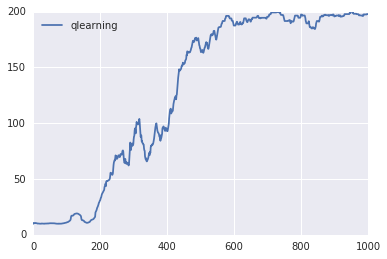

In [0]:
EXPERIMENT_NAME = 'qlearning' # @param

tf.reset_default_graph()
sess = tf.Session()

env = gym.make('CartPole-v0')
EPSILON = 0.1 # @param
qnet = QNet(obs_dim=4, action_dim=2, epsilon=EPSILON)
replay_buffer = ReplayBuffer(obs_dim=4, action_dim=2)

LEARNING_RATE = 1e-3 # @param

qlearning = QLearning(qnet,
                      learning_rate=LEARNING_RATE,)

sess.run(tf.initialize_all_variables())

NUM_ITERATIONS = 1000 # @param
EPISODES_PER_ITERATION = 1 # @param
TEST_EPISODES_PER_ITERATION = 1 # @param
UPDATES_PER_ITERATION = 5 # @param
BATCH_SIZE = 64 #@param
all_actions = []

POLICY_SAVE_FREQUENCY = 20

# Make dictionary for saving policy parameters.
try:
  policy_params[EXPERIMENT_NAME] = {}
except NameError:
  policy_params = {EXPERIMENT_NAME: {}}

training_scores = []
with sess.as_default():
  for i in xrange(NUM_ITERATIONS):
    # Collect episodes.
    for _ in xrange(EPISODES_PER_ITERATION):
      collect_episode(env, 
                      qnet, 
                      replay_buffer=replay_buffer)
    # Train
    avg_loss = 0
    try:
      total_loss = 0
      for _ in xrange(UPDATES_PER_ITERATION):
        minibatch = replay_buffer.sample_minibatch(batch_size=BATCH_SIZE)
        total_loss += qlearning.train(minibatch)
      avg_loss = total_loss / UPDATES_PER_ITERATION
    except IndexError:
      # Replay Buffer does not have enough transitions yet.
      pass
    
    # Collect test episodes.
    test_episodes = []
    for _ in xrange(TEST_EPISODES_PER_ITERATION):
      test_episodes.append(collect_episode(env,
                                           qnet,
                                           epsilon=0.0))
    
    # Sum rewards across episodes.
    avg_reward = sum(map(lambda episode: sum(episode[2]),
                           test_episodes)) / TEST_EPISODES_PER_ITERATION
    training_scores.append(avg_reward)
    sys.stdout.write('\r{}/{} Iterations, {} Avg reward this iteration. {} Avg loss this iteration.'.format(i+1, NUM_ITERATIONS, avg_reward, avg_loss))
    
    # Save intermittent policy parameters for running episodes later.
    if i % POLICY_SAVE_FREQUENCY == 0:
      policy_params[EXPERIMENT_NAME][i] = qnet.get_params()        
  
# Avg training_scores by sliding window.
SLIDING_WINDOW_SIZE = 30 # @param
training_scores = [np.mean(training_scores[max(i-SLIDING_WINDOW_SIZE, 0):i+1])
                   for i in xrange(len(training_scores))]

# Save training_scores list by EXPERIMENT_NAME.
try:
  all_scores[EXPERIMENT_NAME] = training_scores
except NameError:
  all_scores = {EXPERIMENT_NAME: training_scores}

# Plot all experiments so far.
experiment_names = all_scores.keys()
for name in experiment_names:
  plt.plot(all_scores[name])
plt.legend(experiment_names, loc='upper left')


In [0]:
# @title Clear Scores
try:
  del all_scores
  del policy_params
except NameError:
  pass

# Observing Episodes

Load the policy parameters from different points in training, and rerun this code block to generate & visualize a new episode.

NOTE: This will only work if you have started the colab kernel manually on your desktop machine. It will not work if you started it through an ssh connection.

[2017-09-11 10:43:26,358] Making new env: CartPole-v0



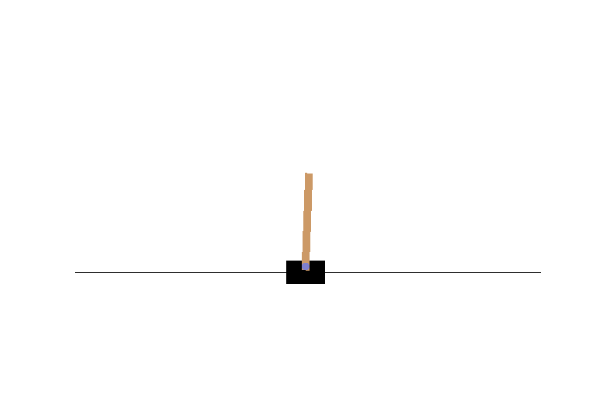
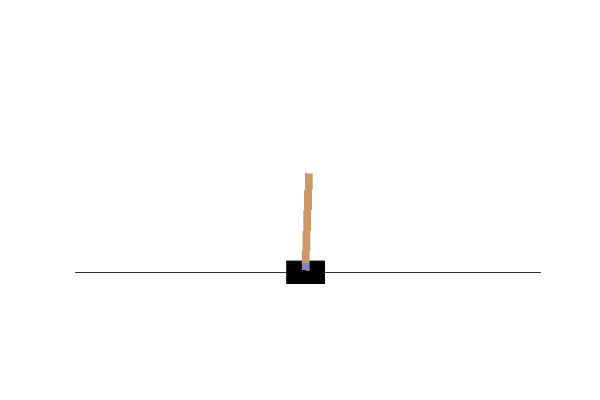
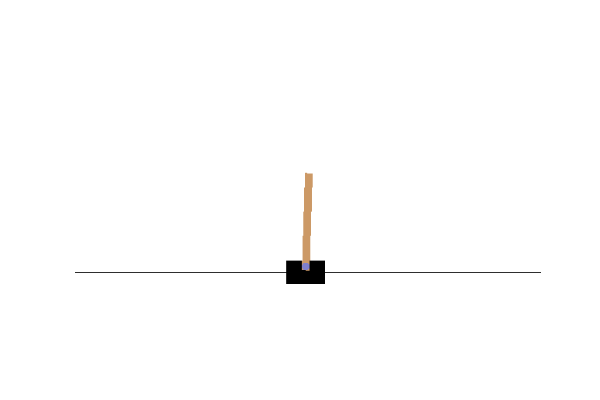
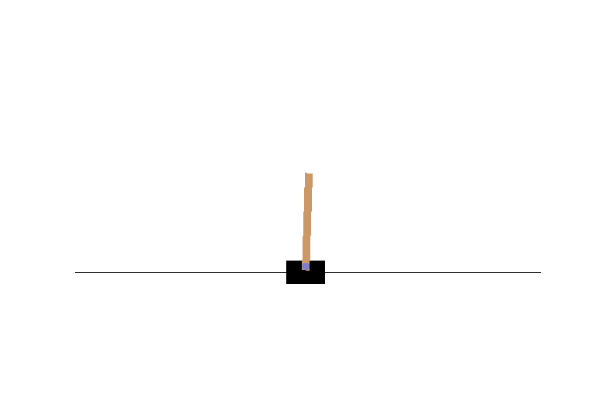
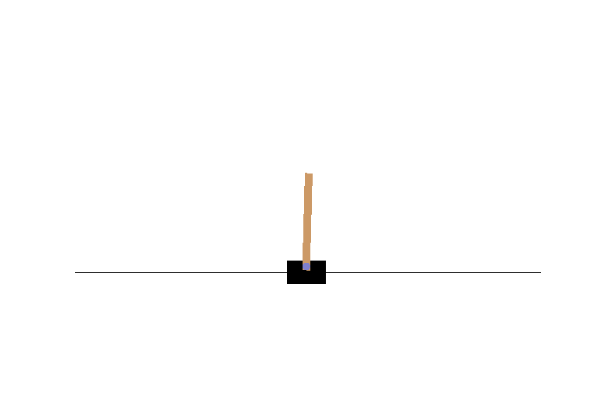
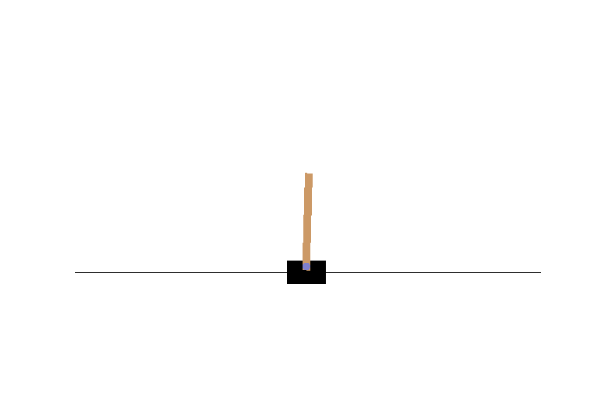
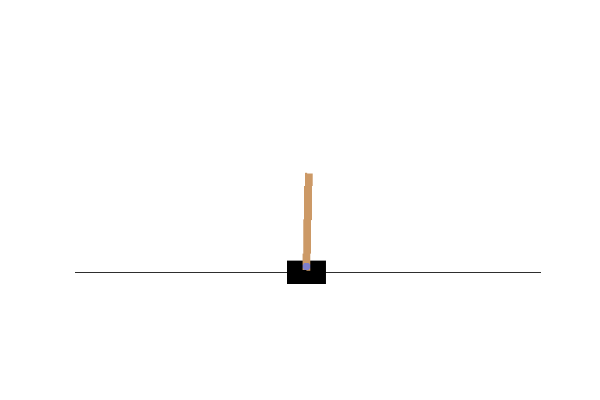
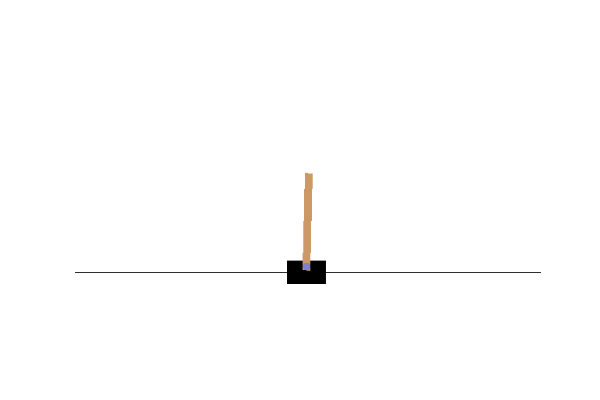
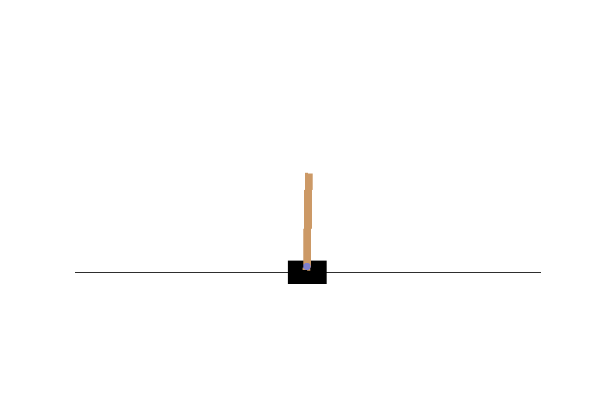
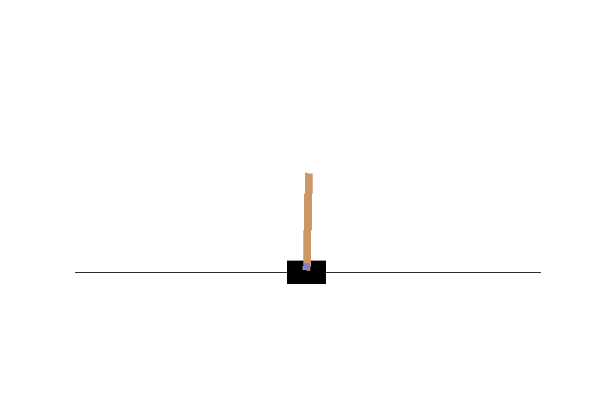
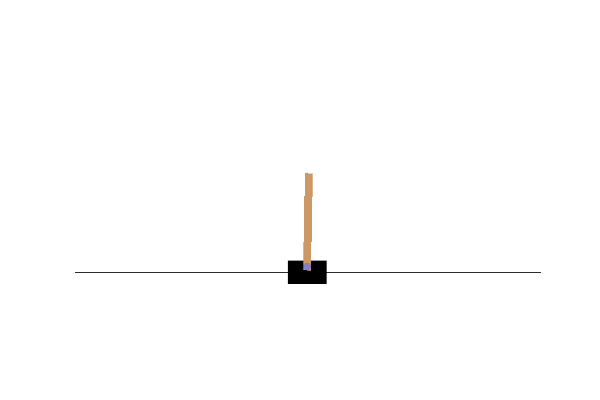
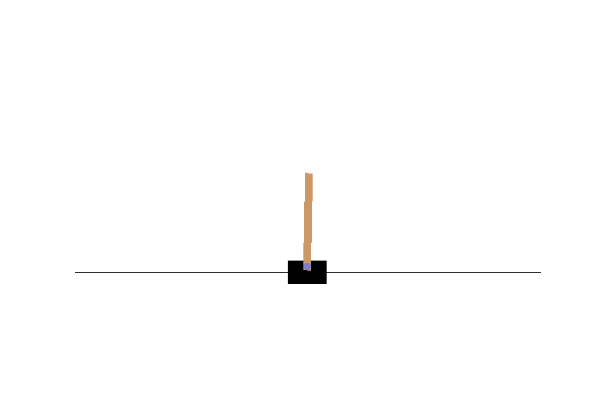
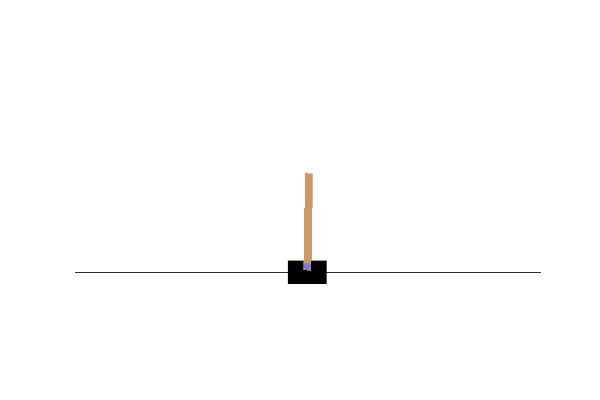
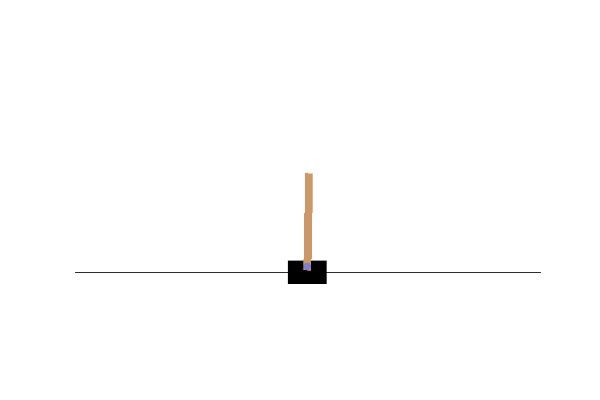
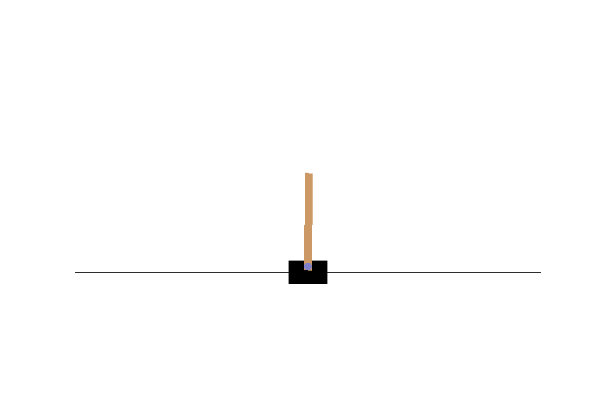
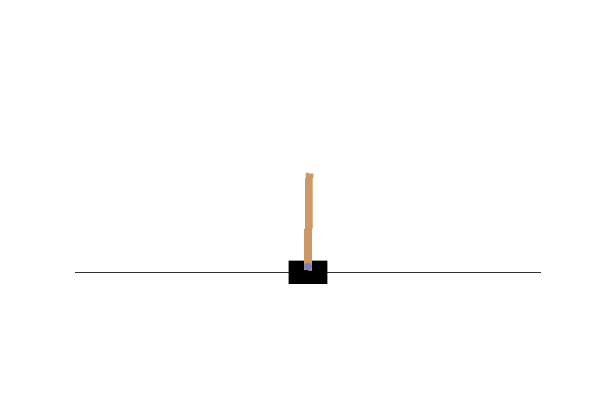
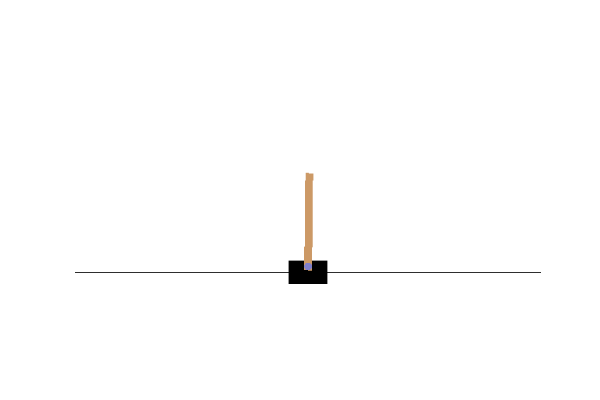
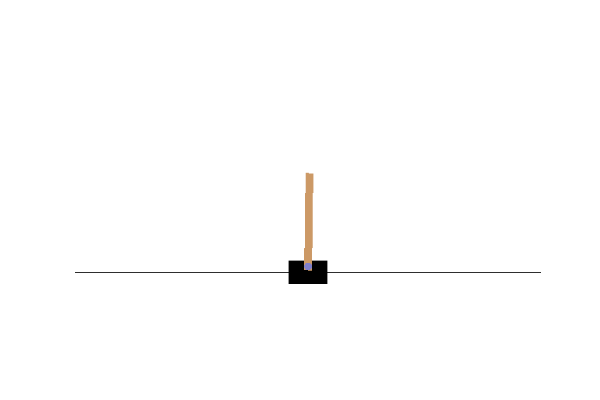
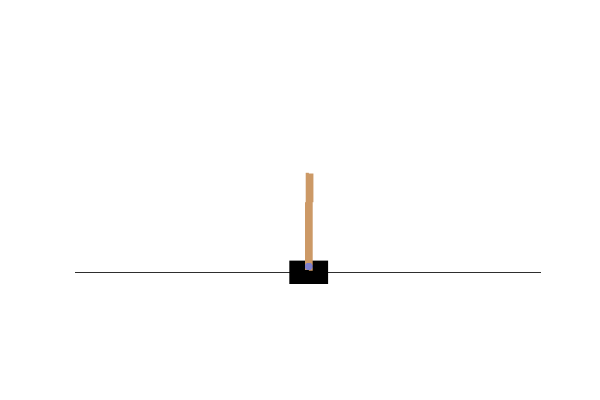
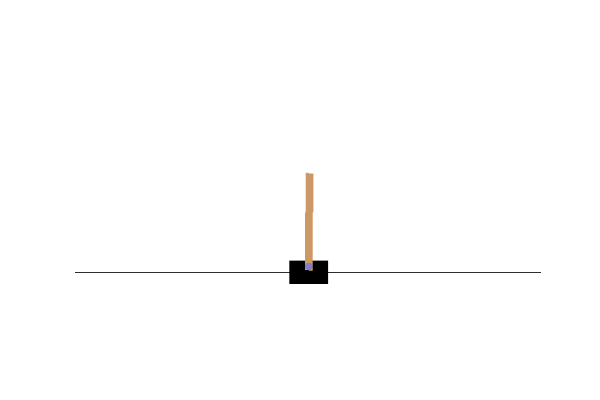
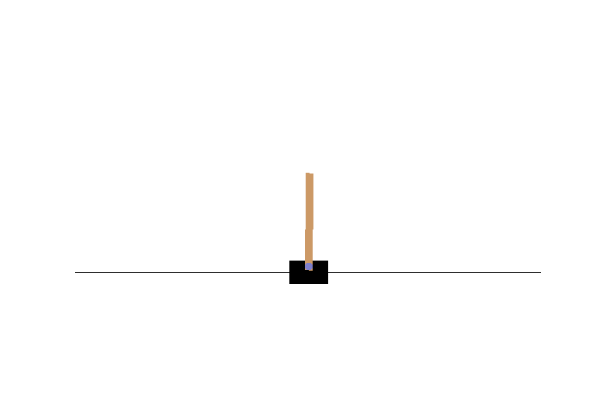
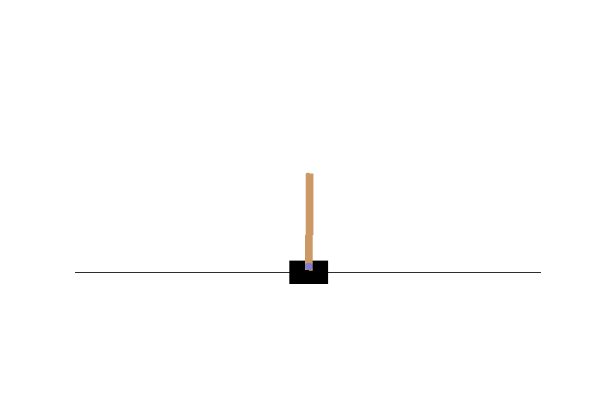
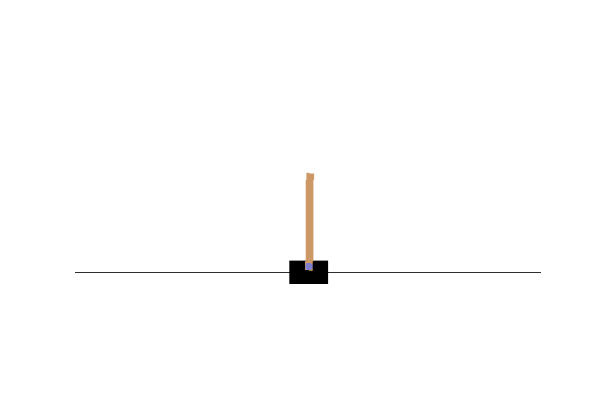
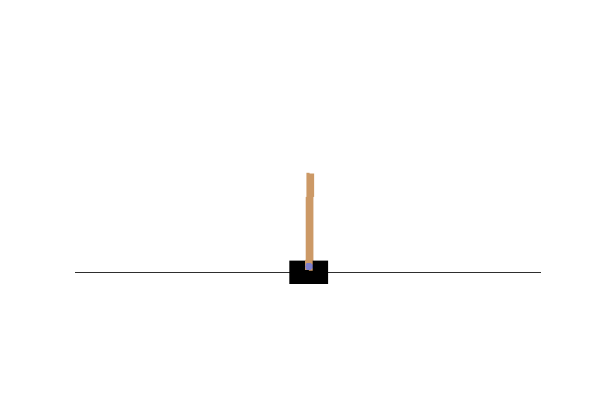
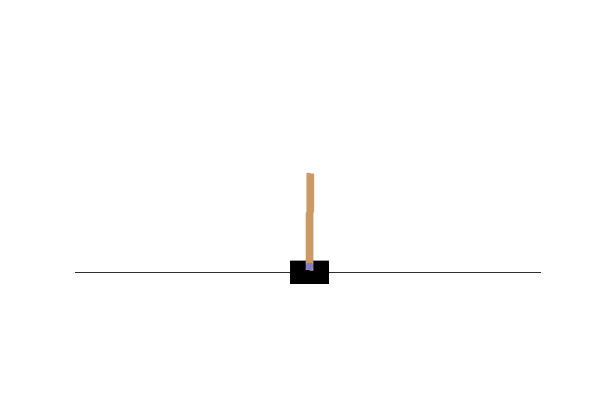
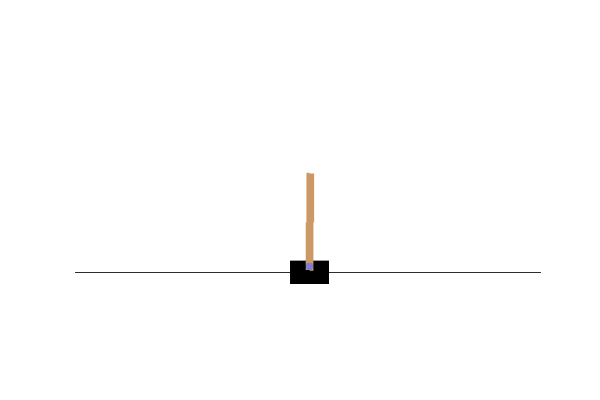
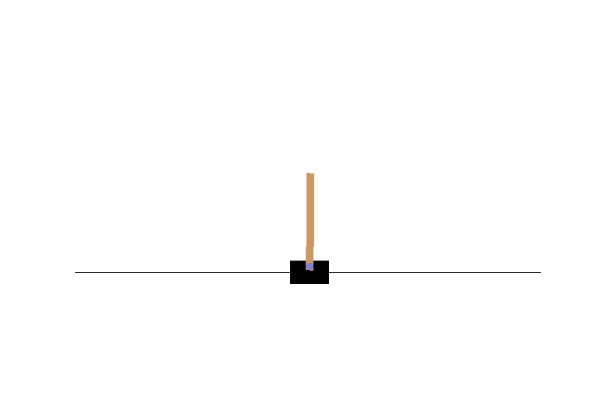
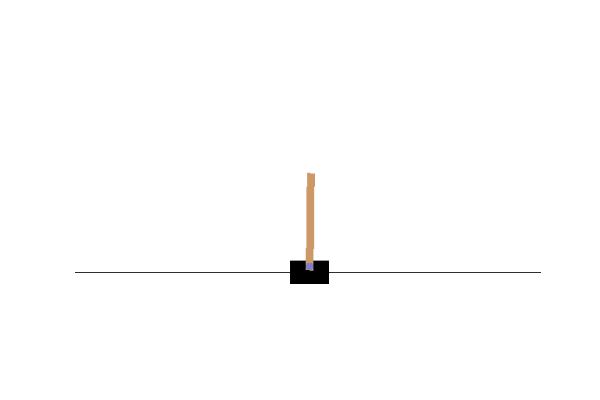
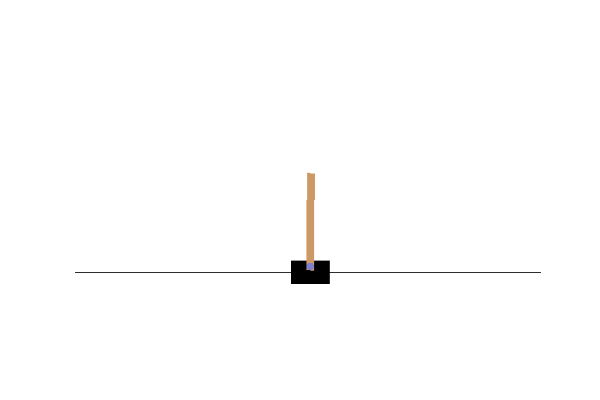
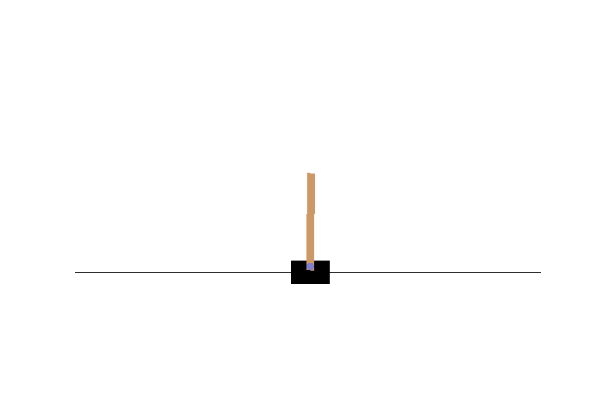
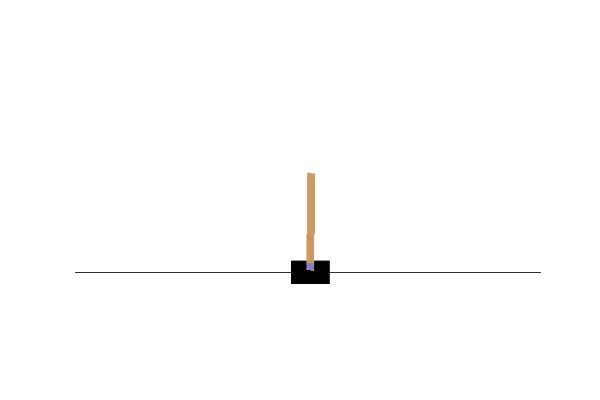
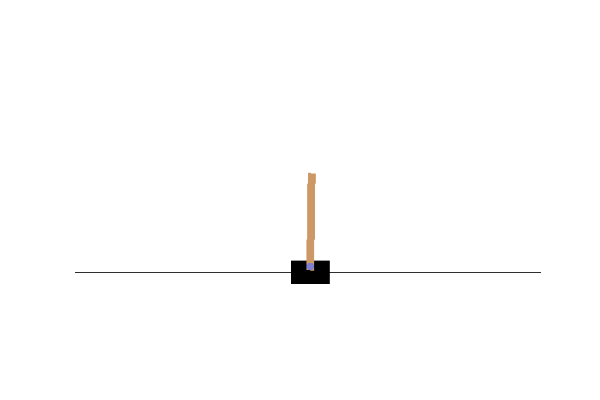
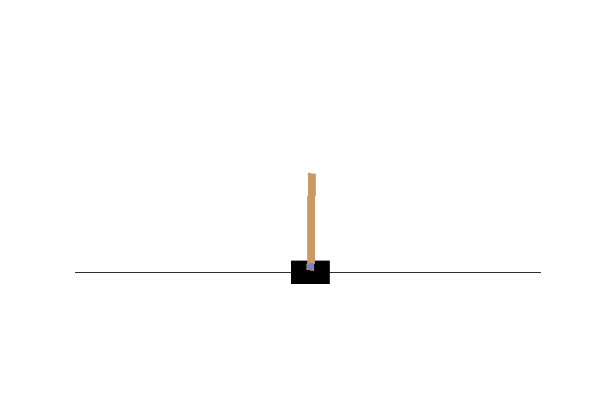
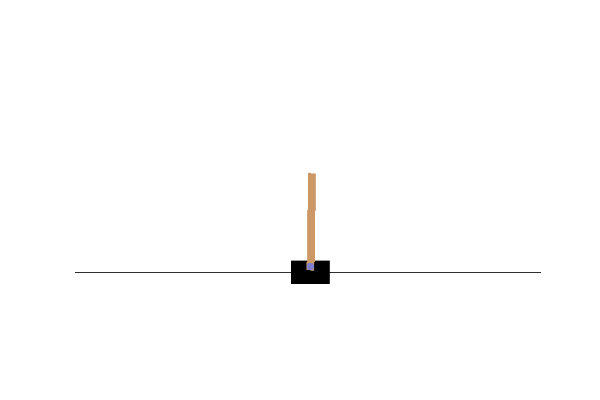
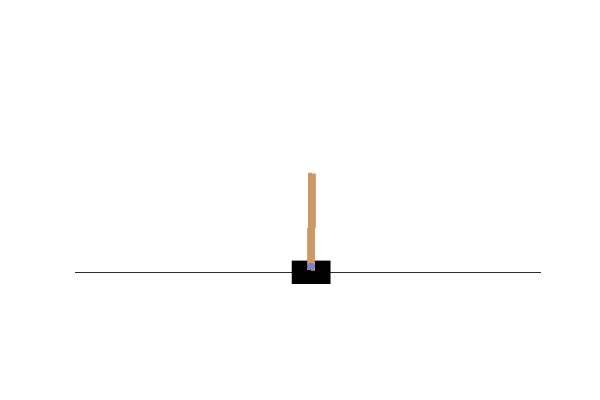
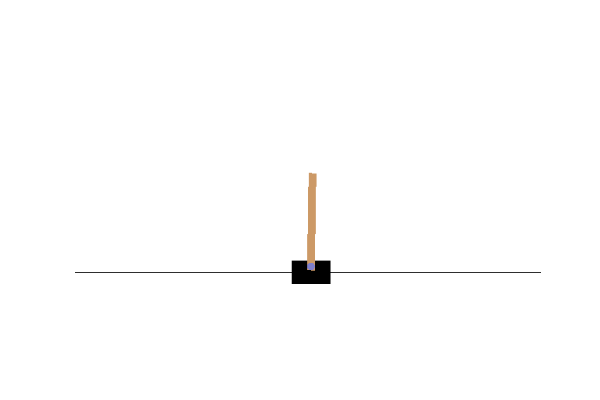
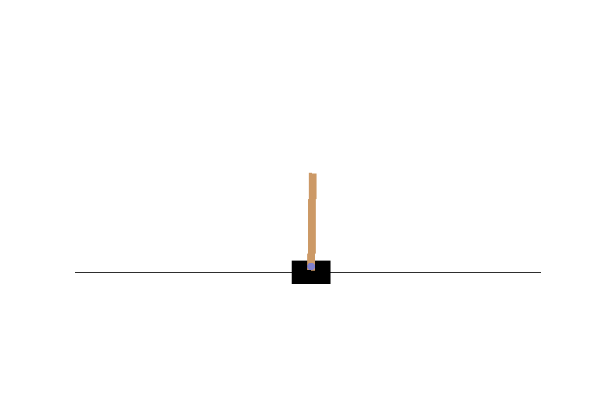
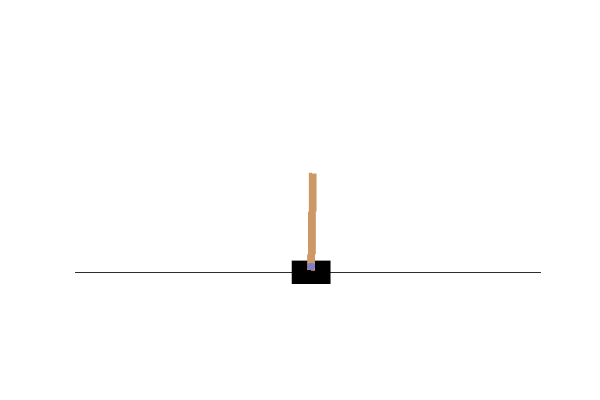
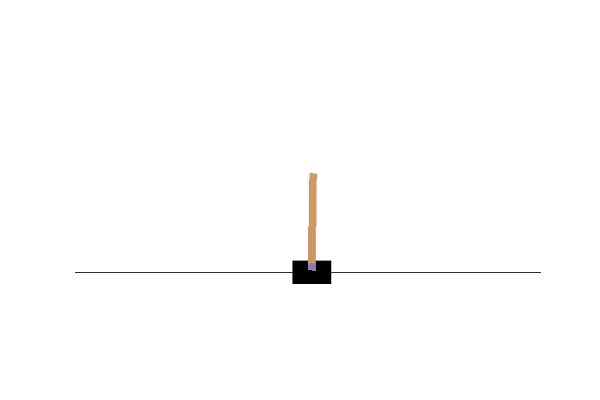
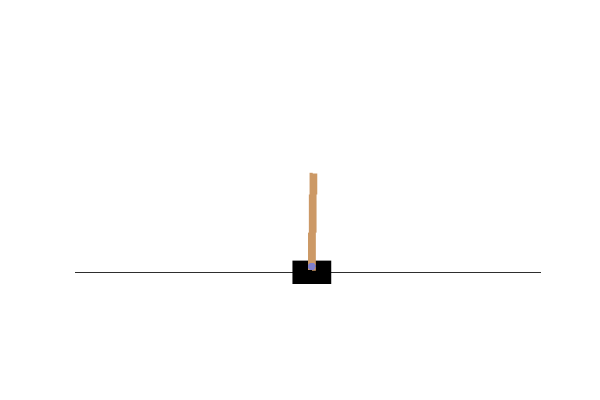
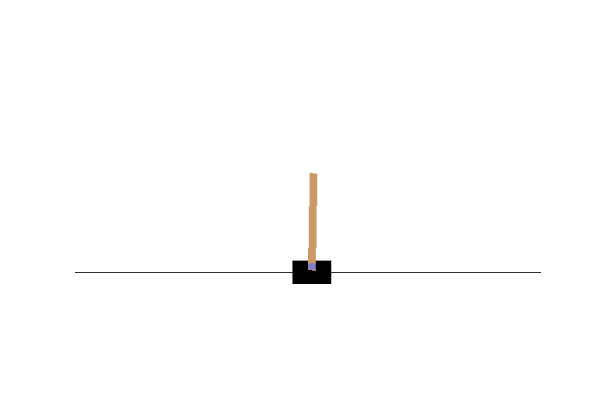
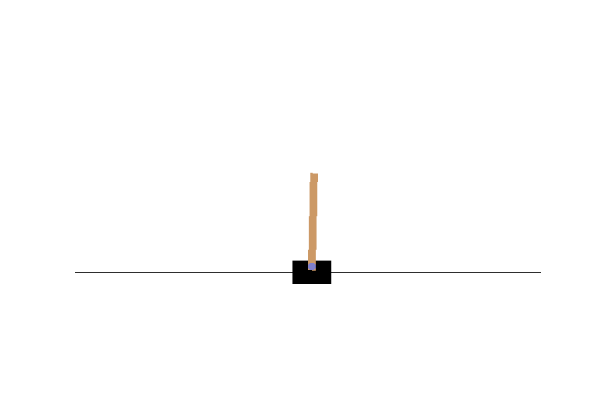
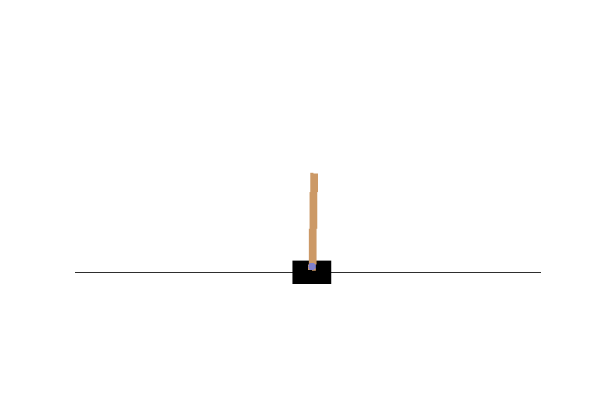
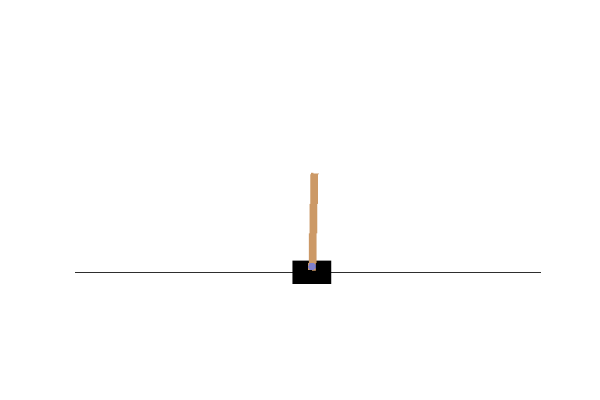
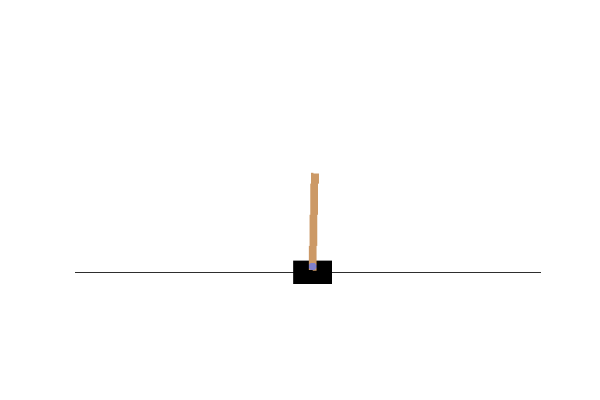
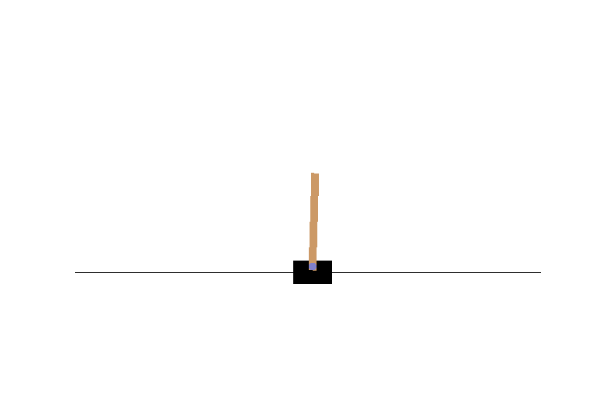
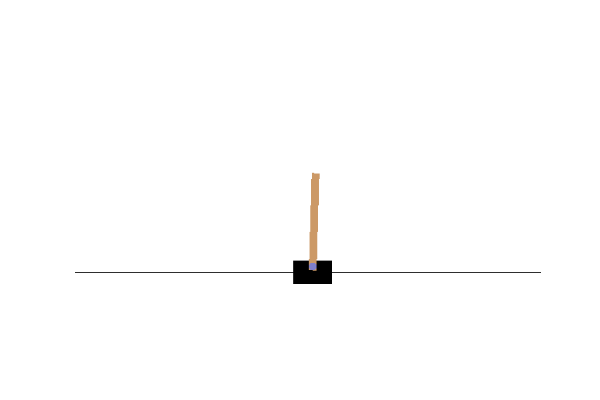
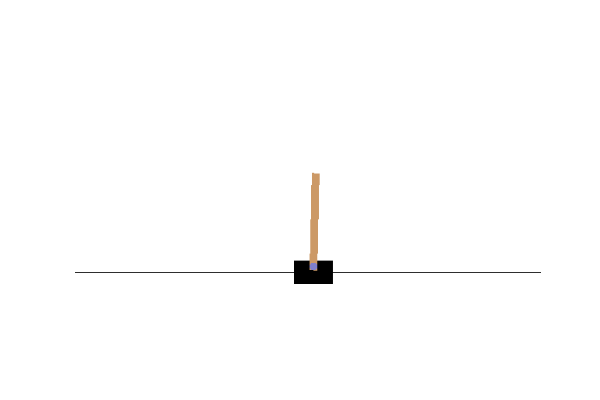
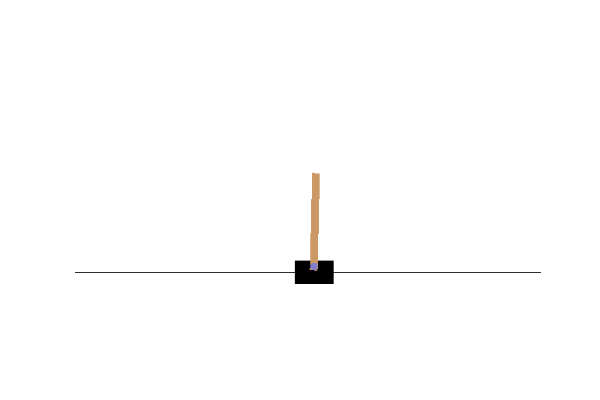
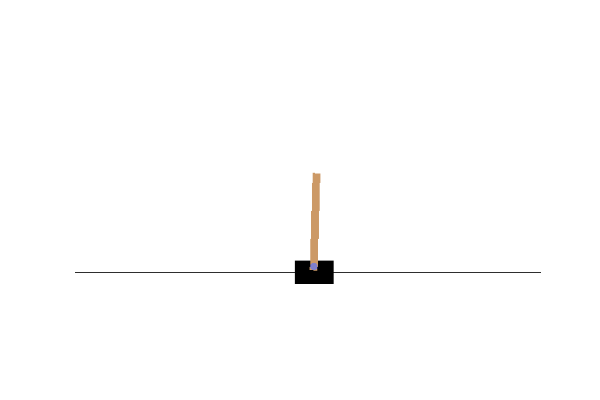
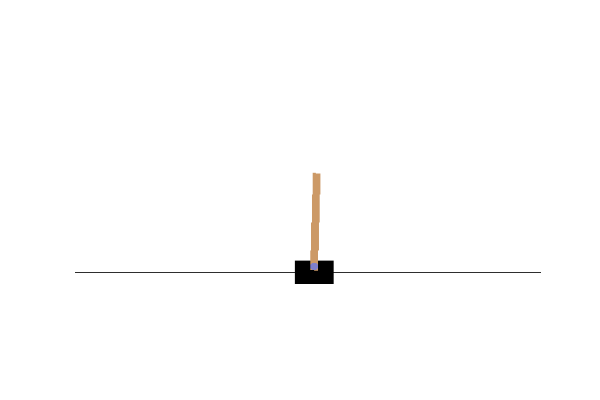
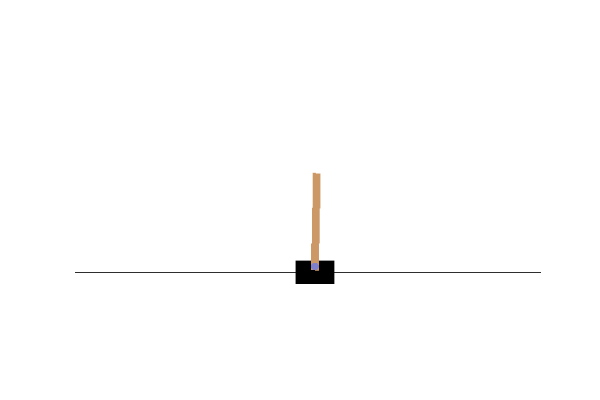
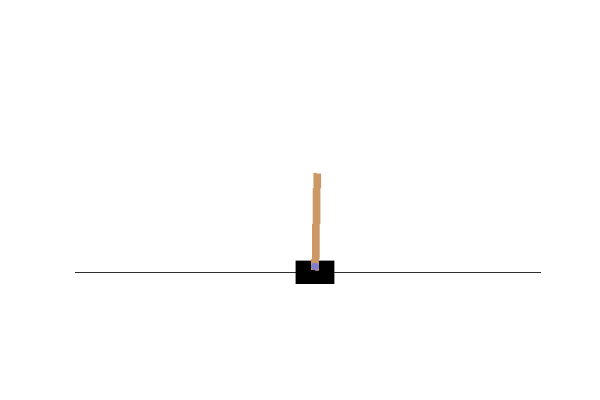
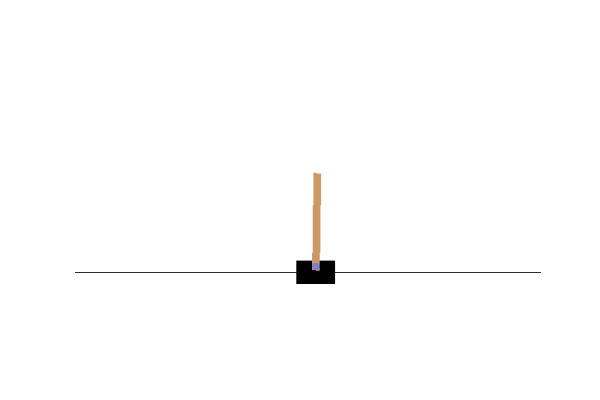
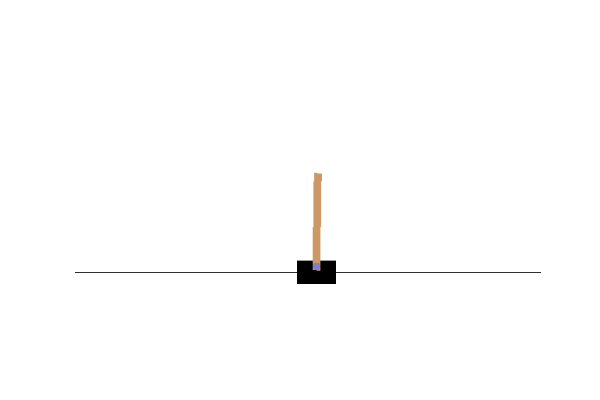
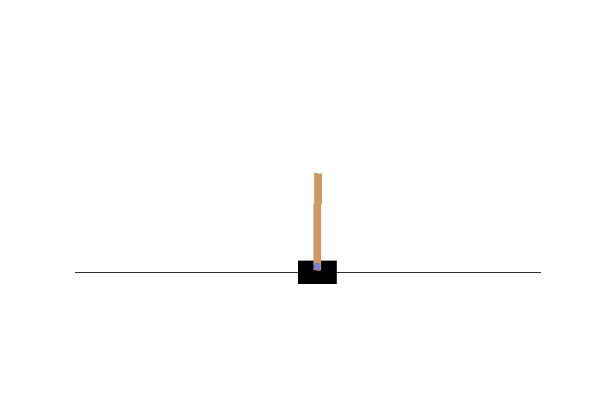
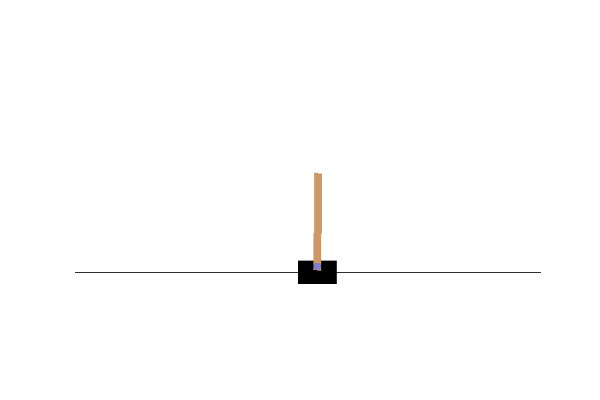
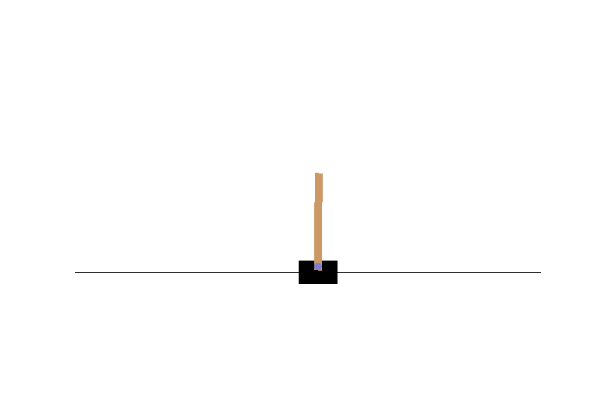
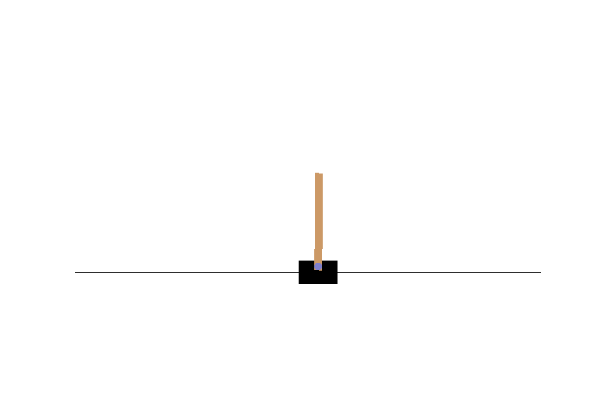
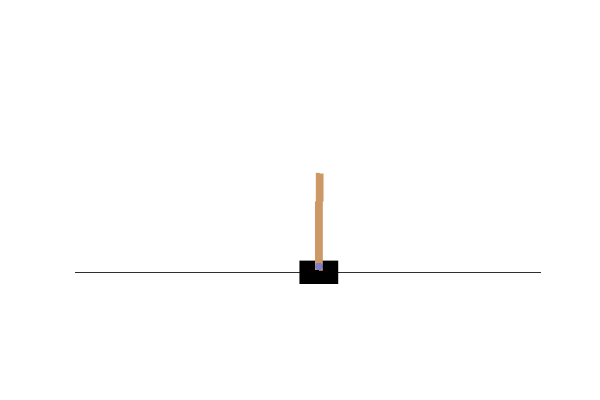
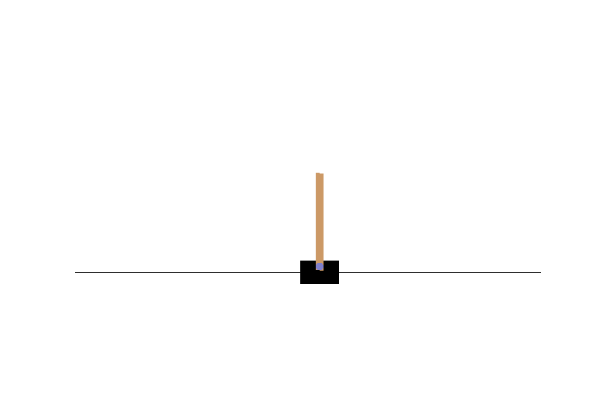
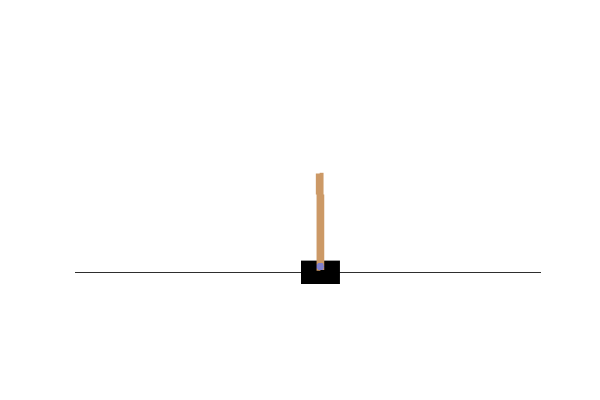
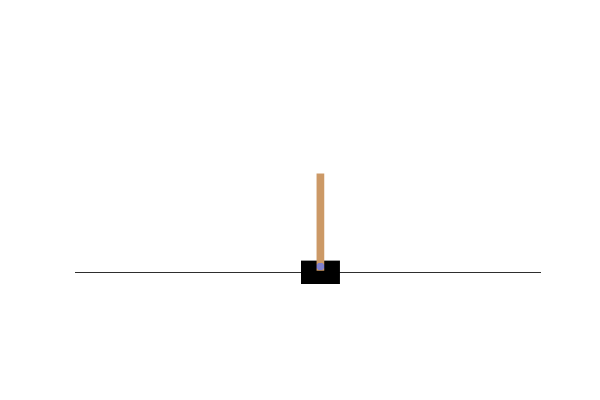
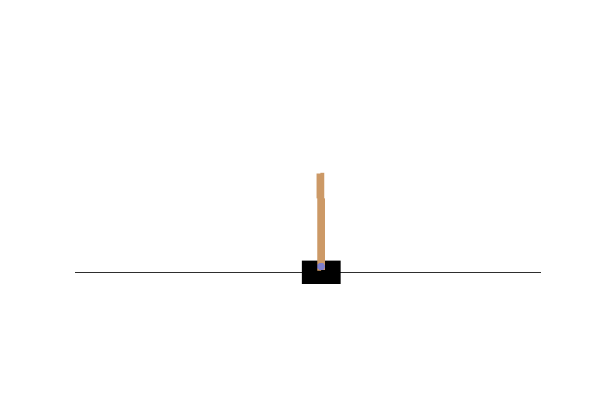
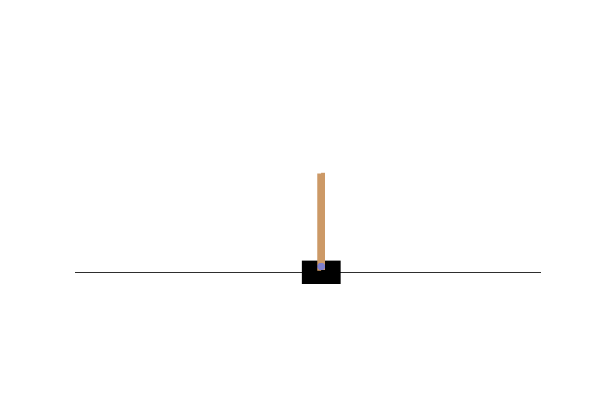
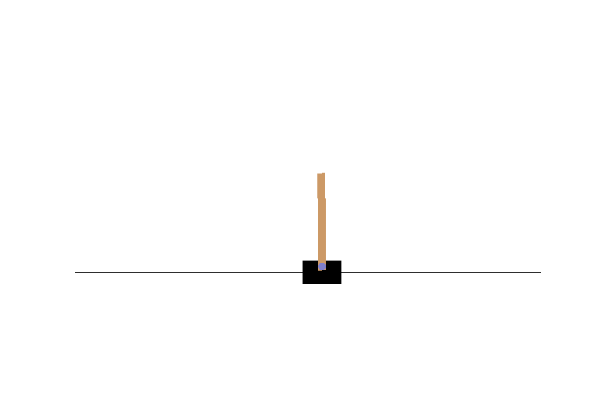
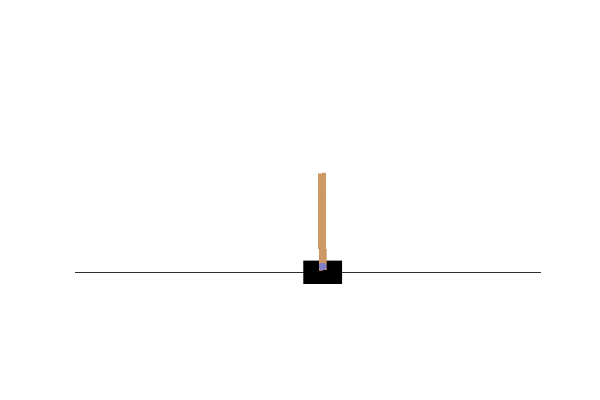
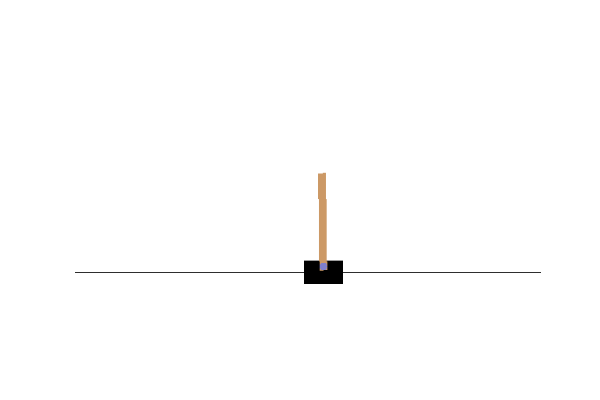
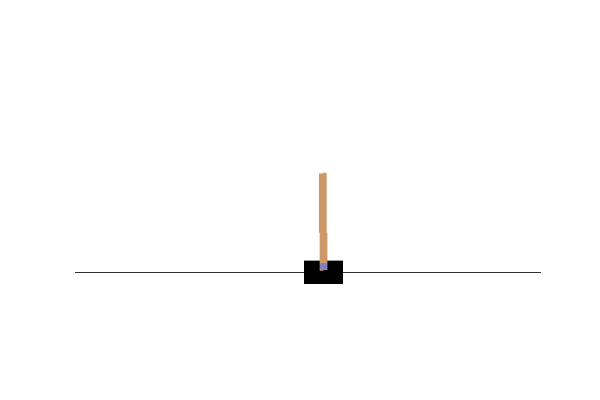
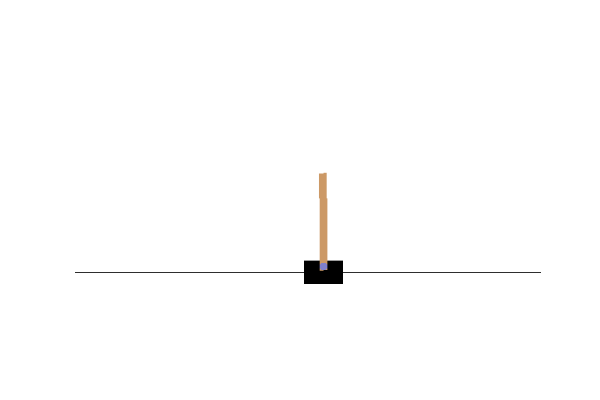
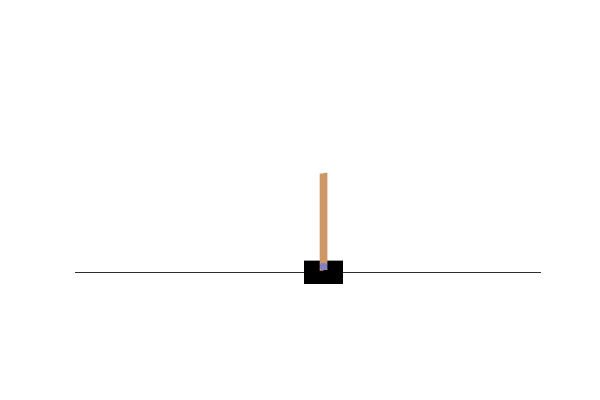
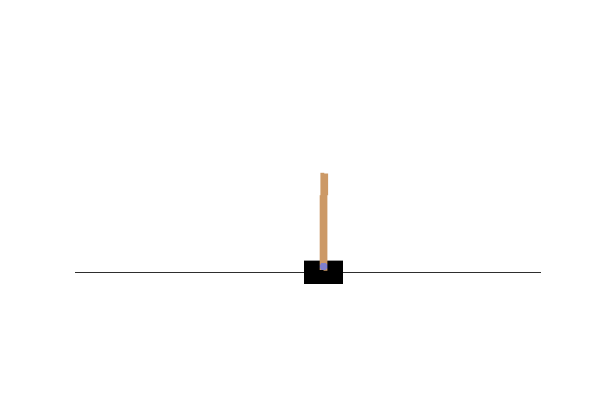
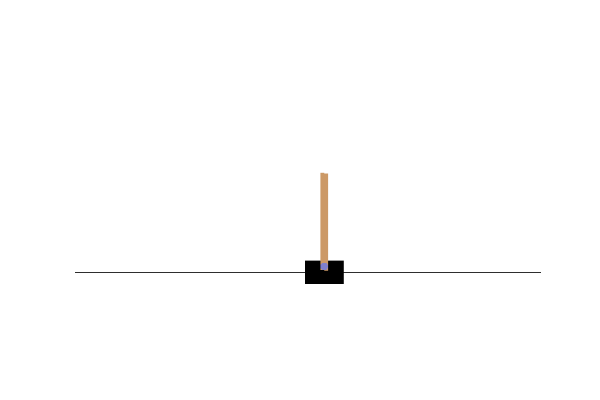
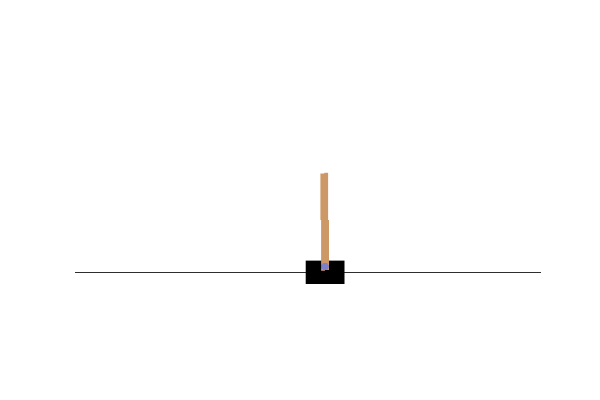
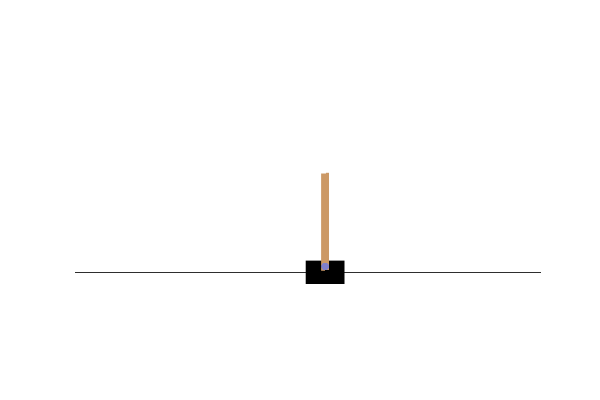
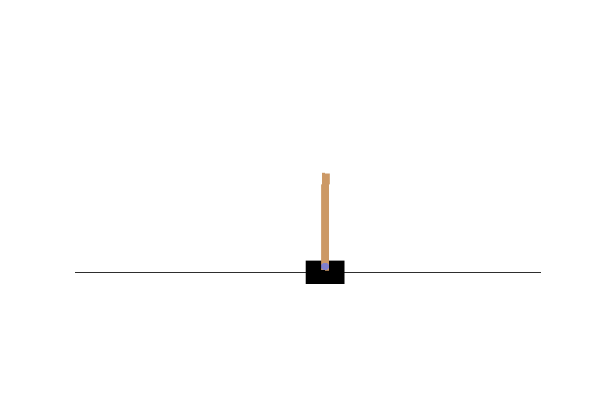
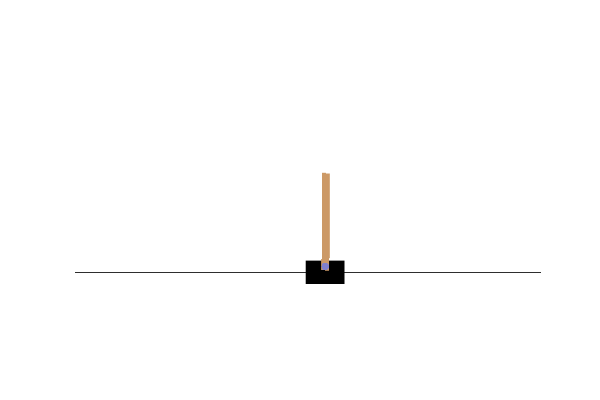
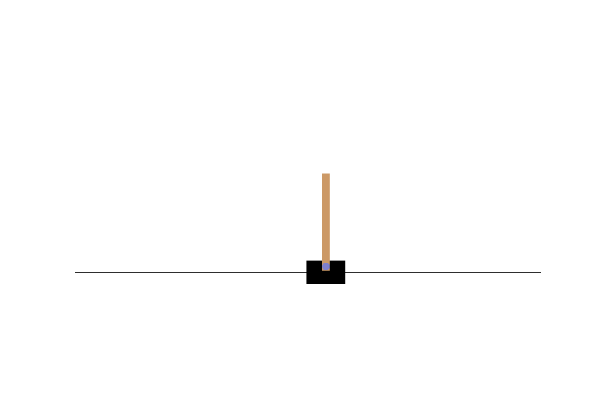
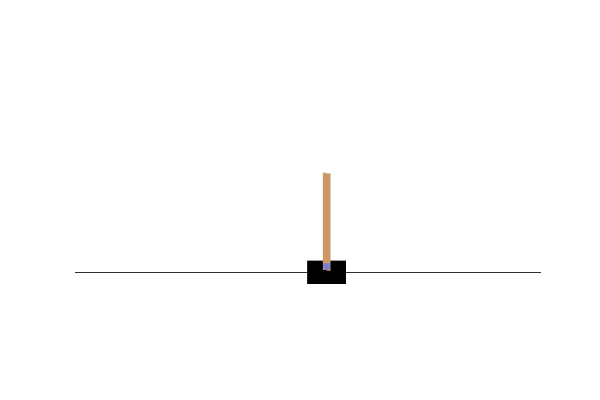
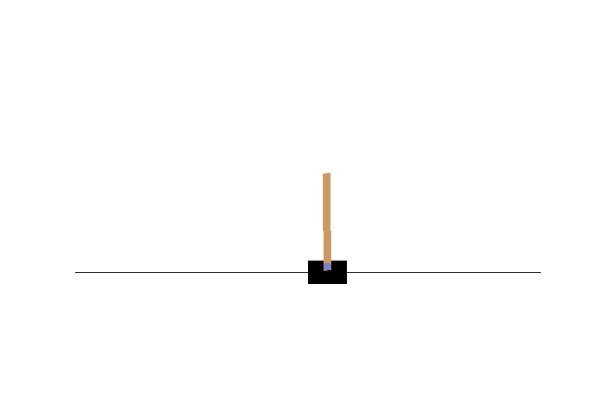
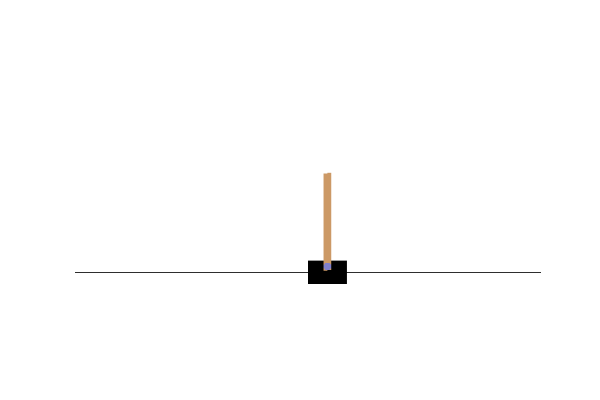
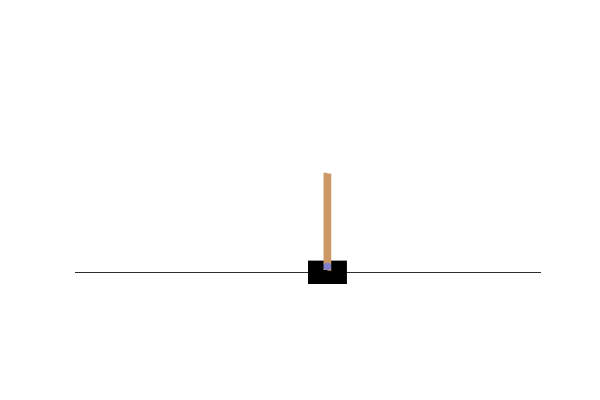
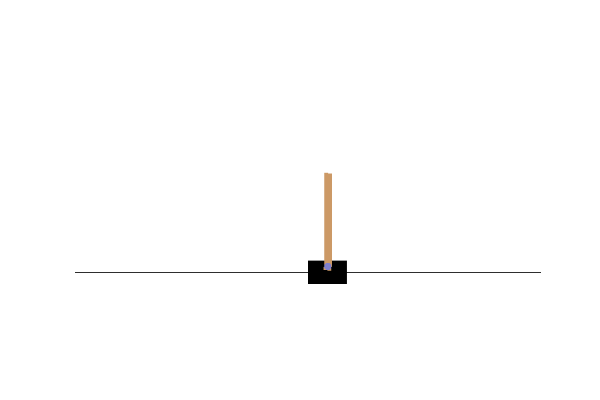
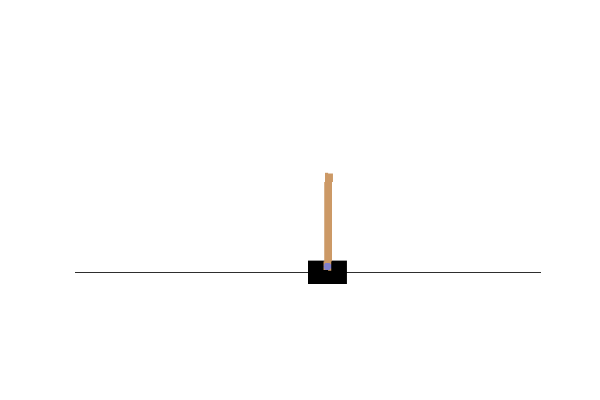
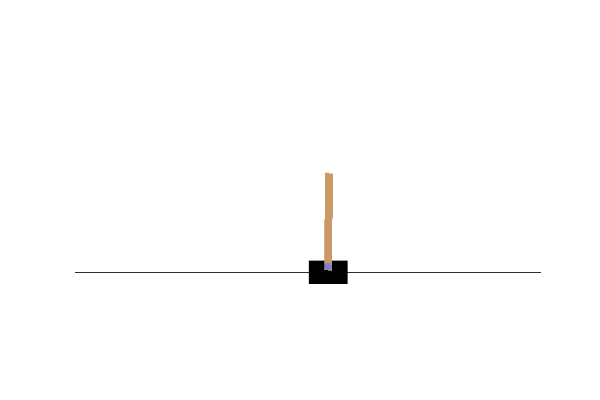
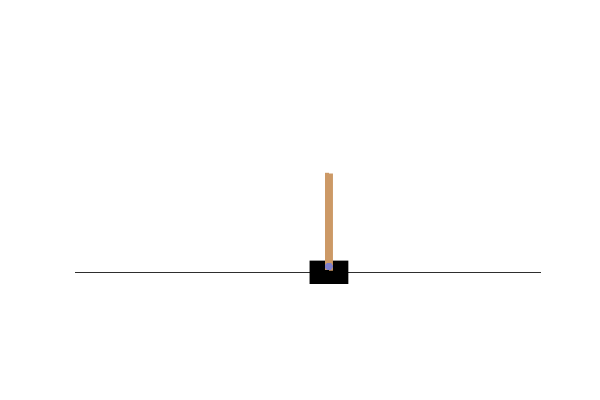
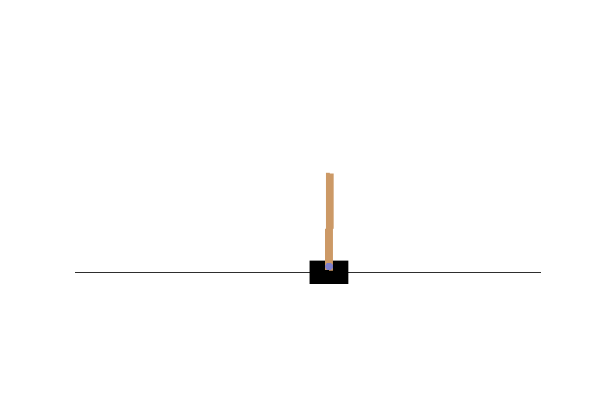
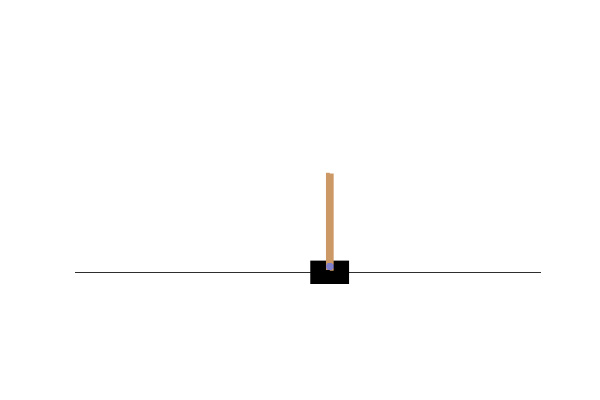
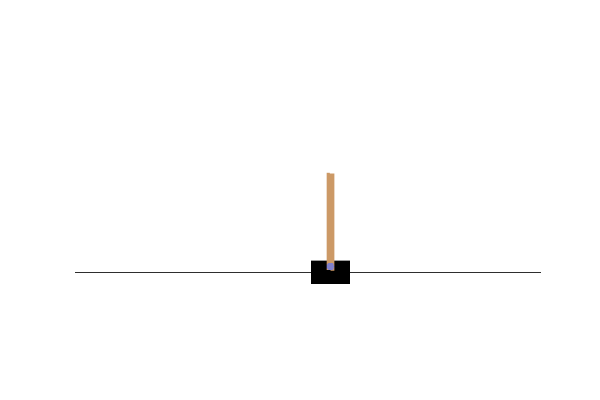
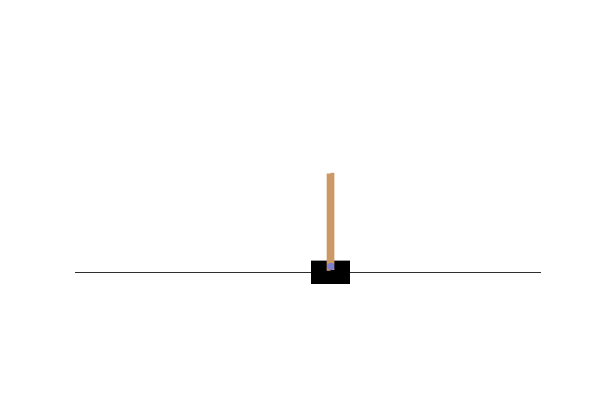
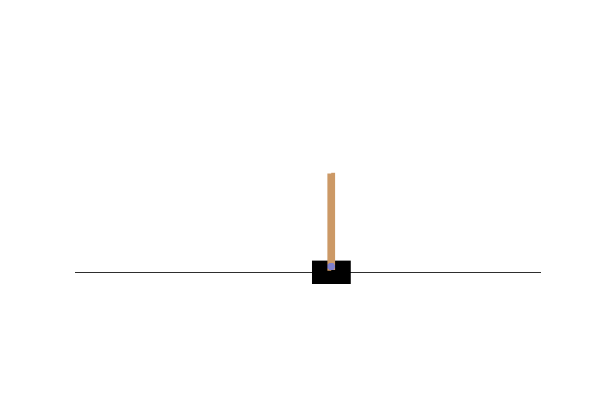
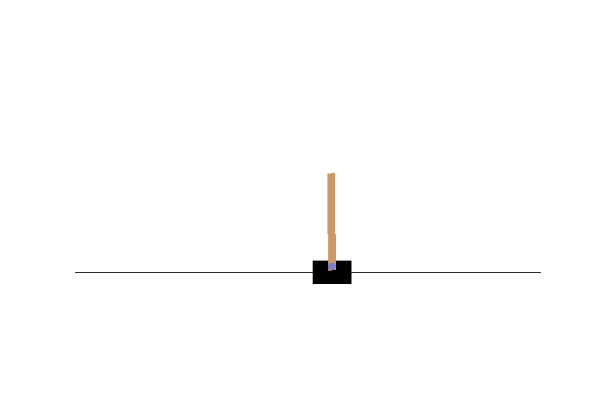
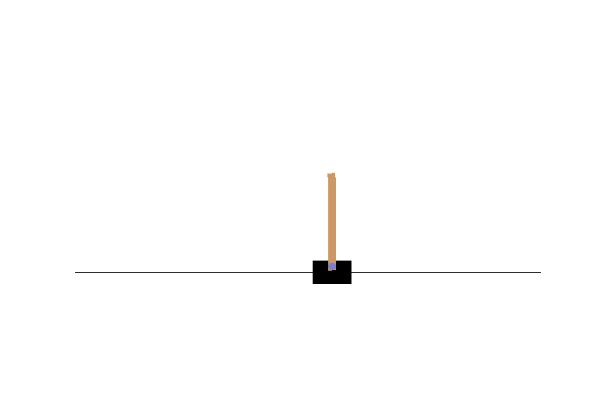
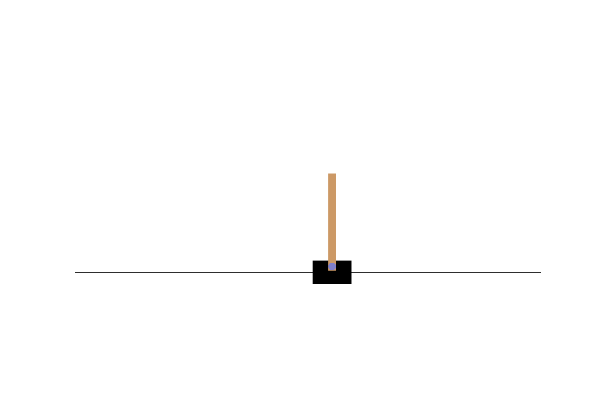
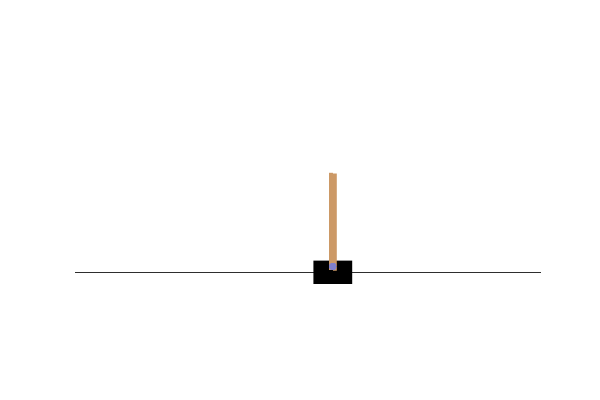
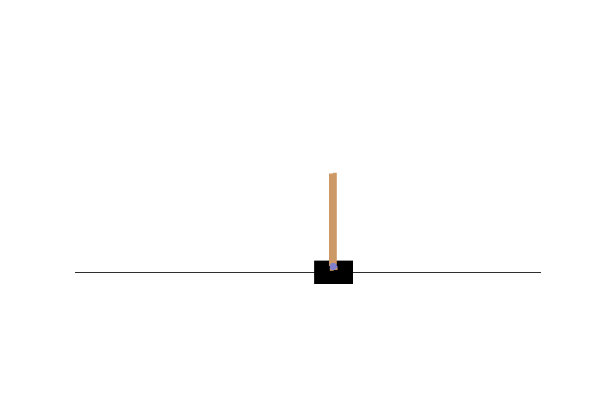
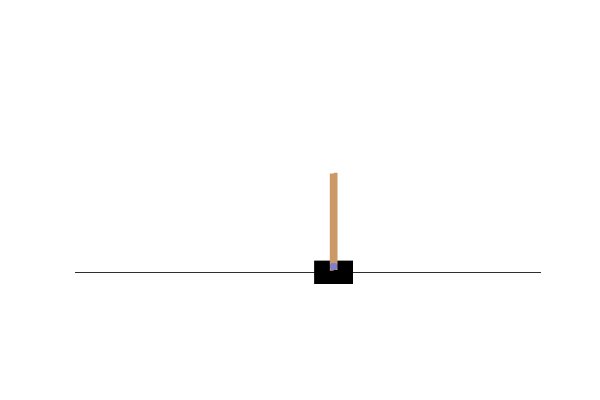
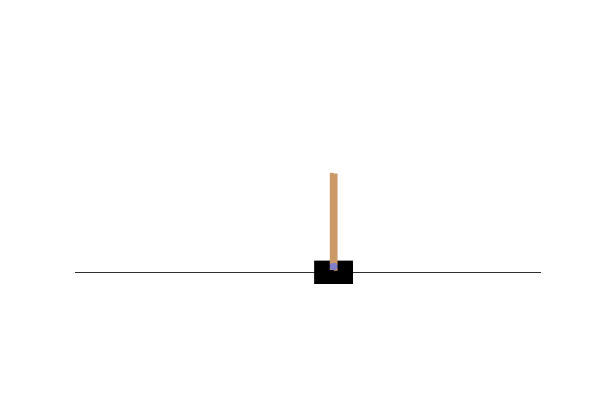
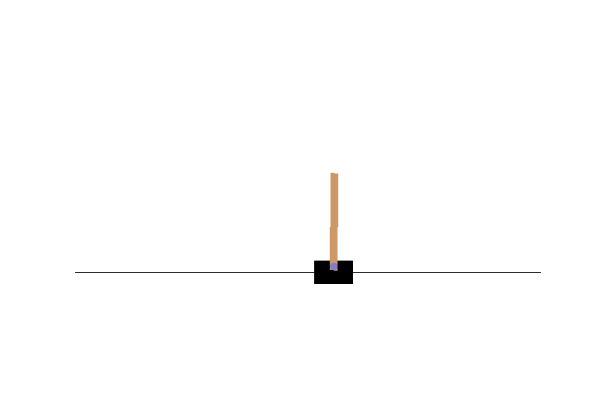
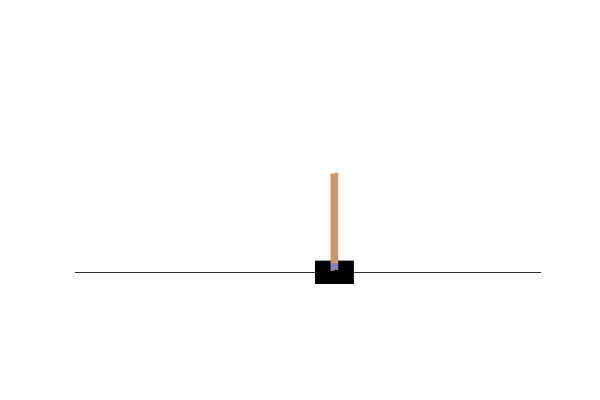
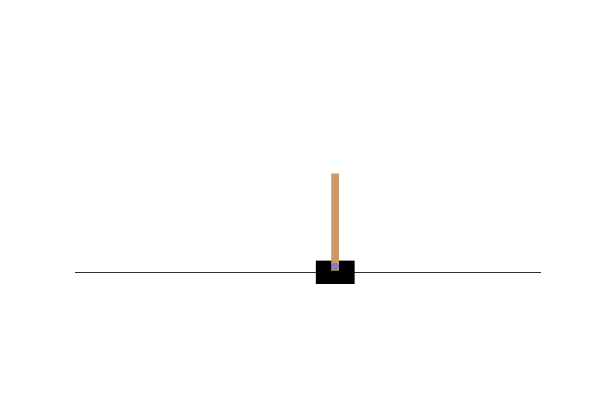
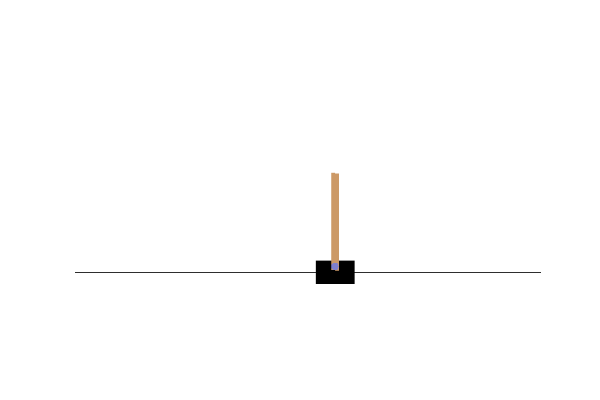
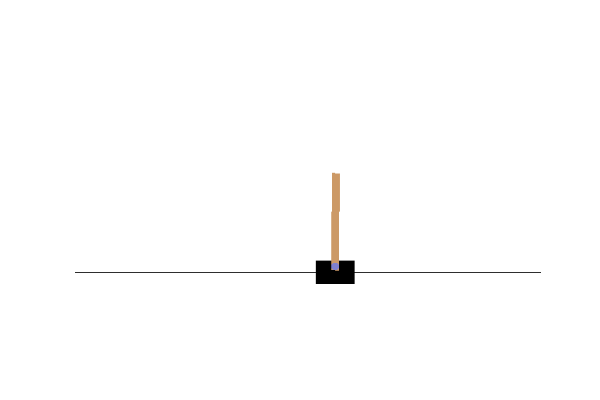
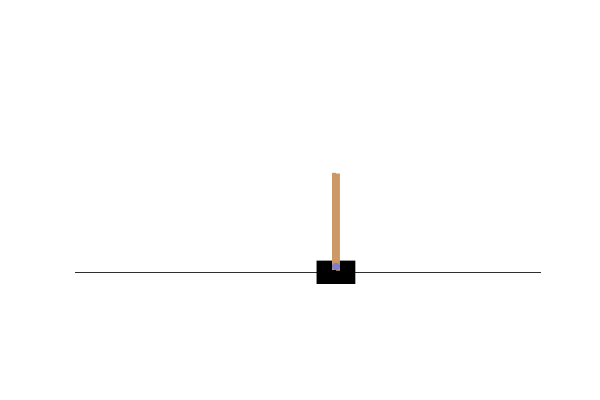
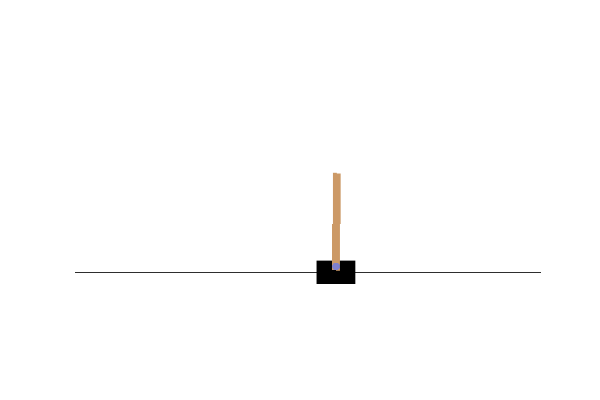
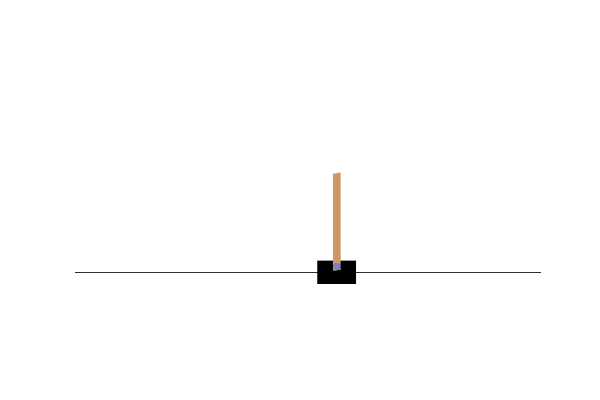
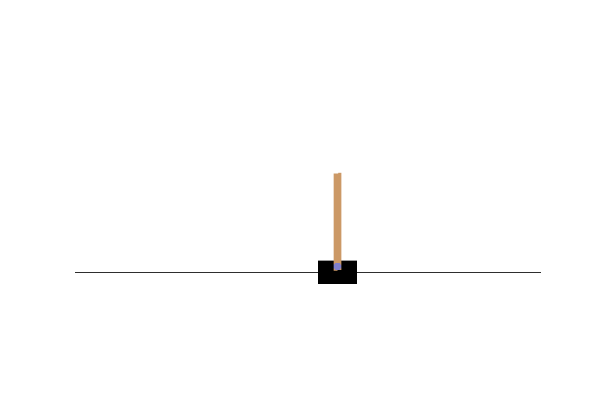
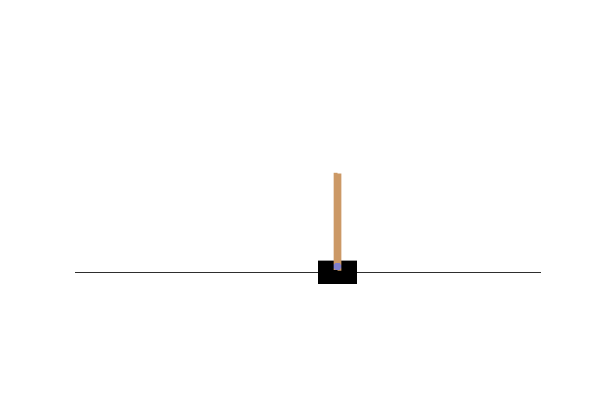
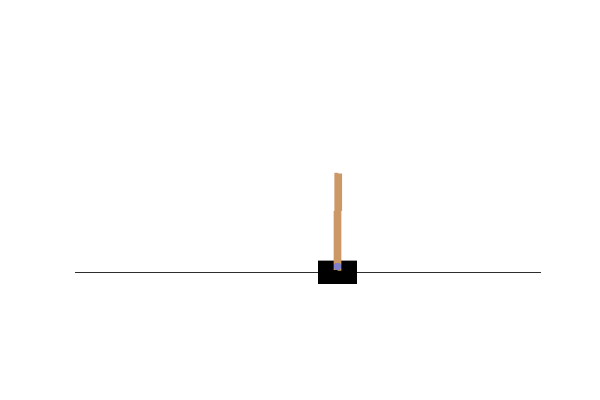
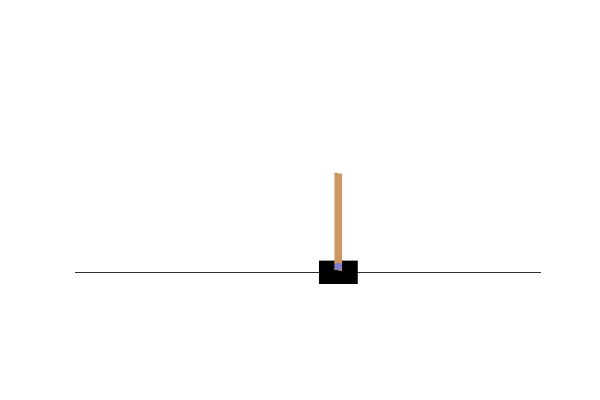
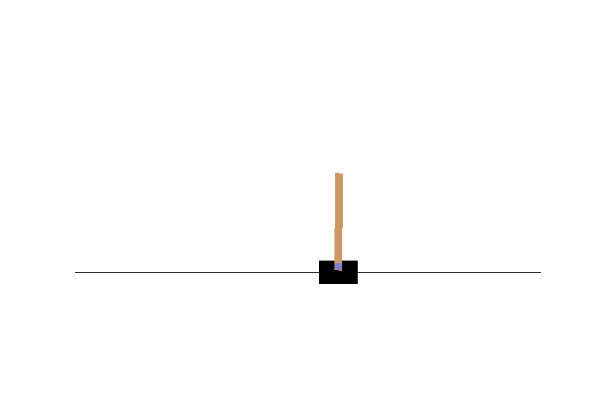
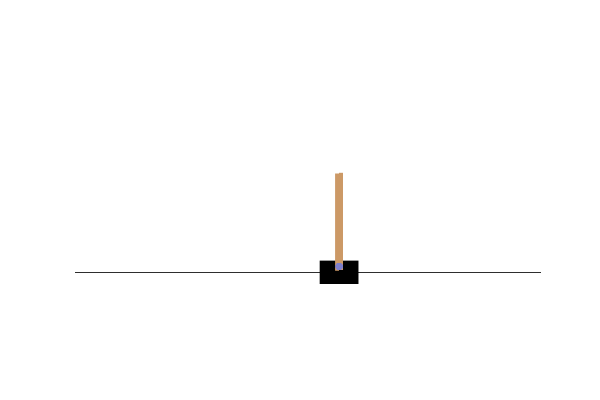
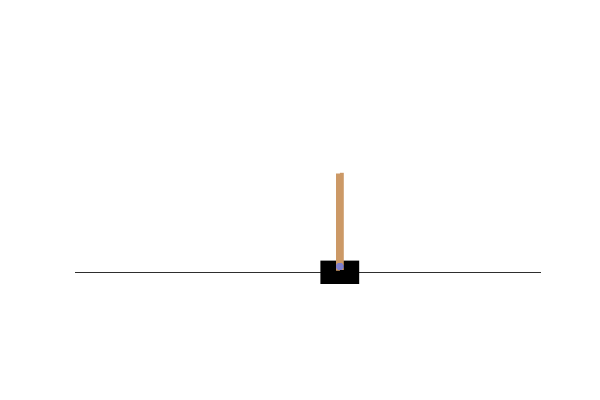
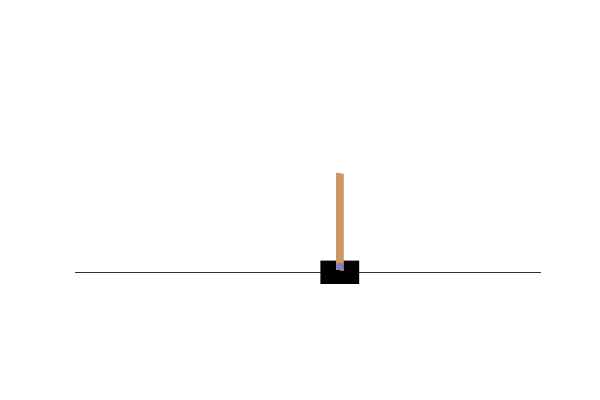
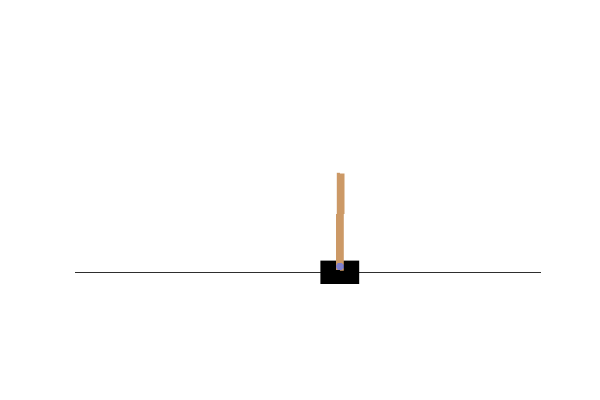
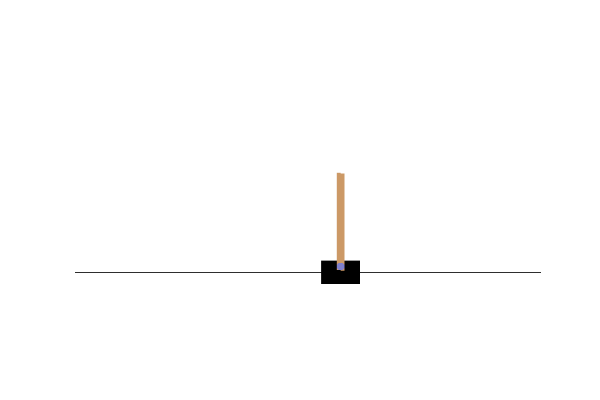
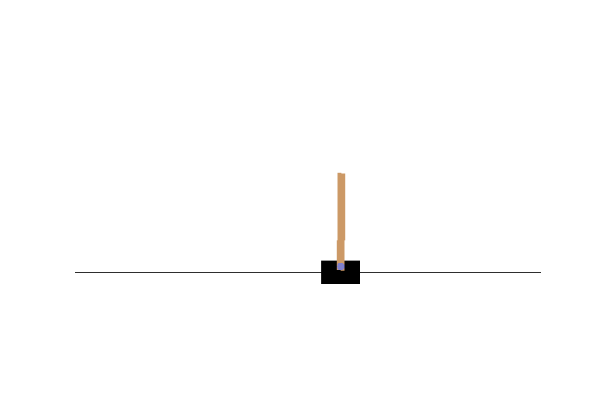
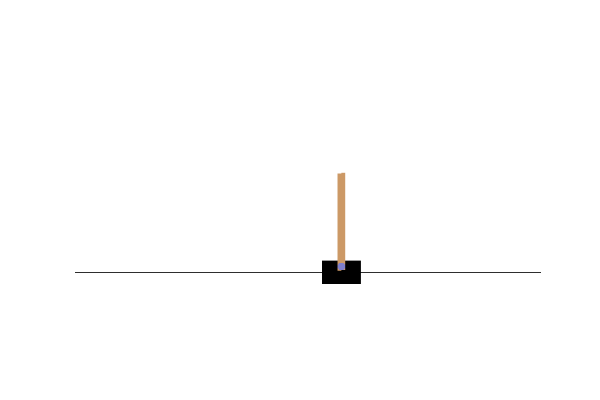
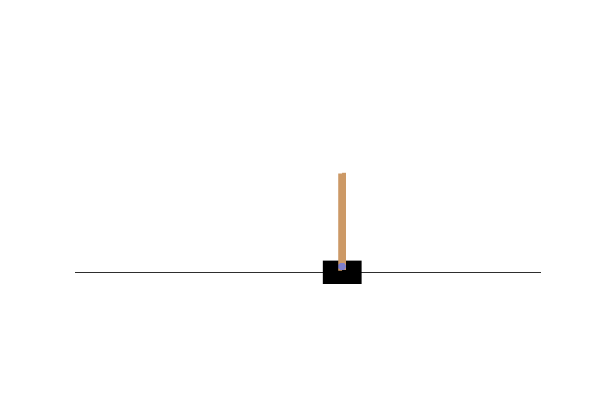
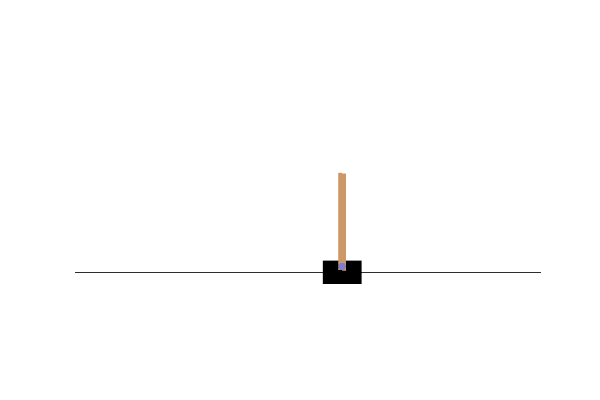
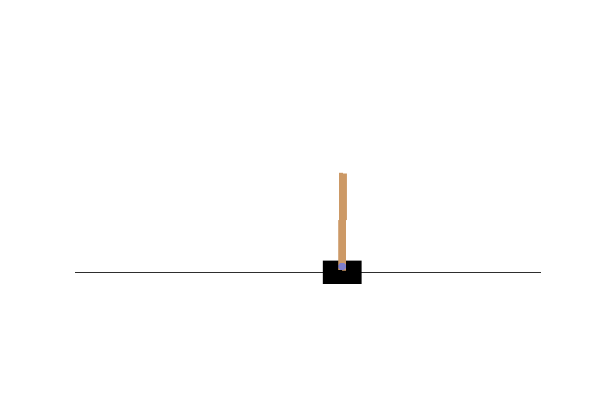
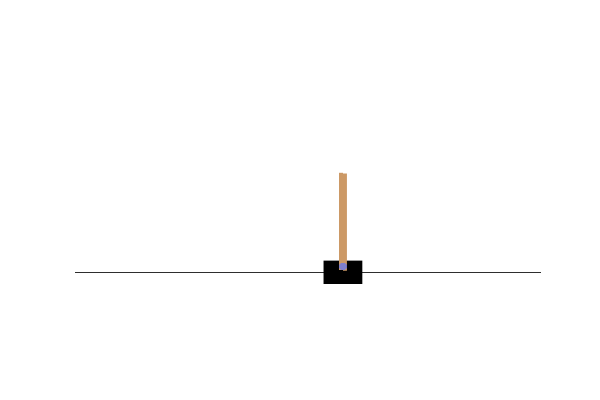
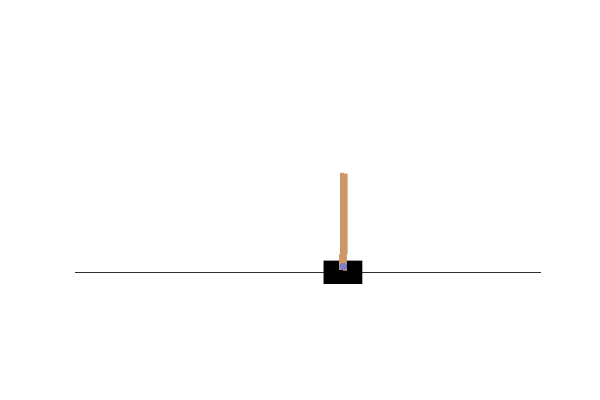
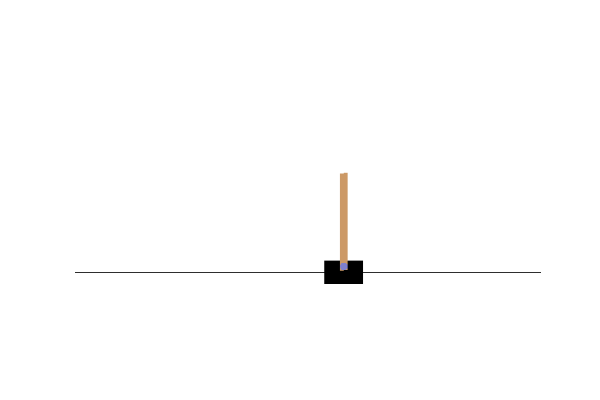
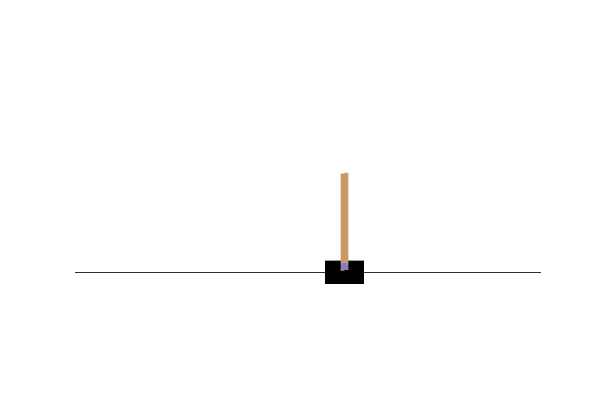
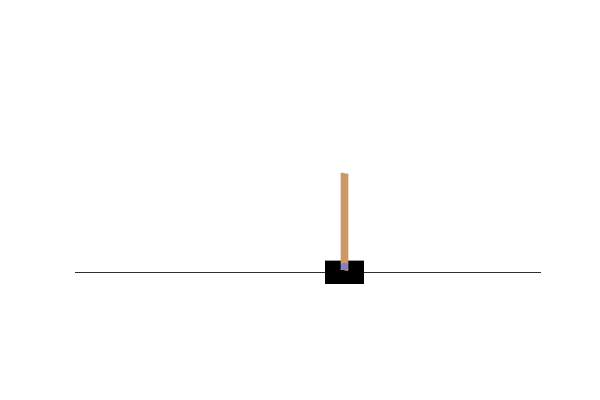
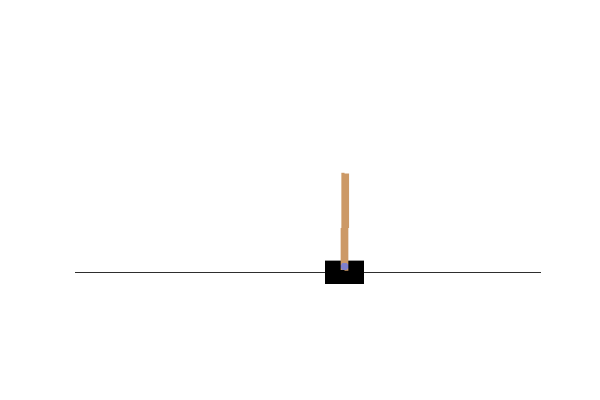
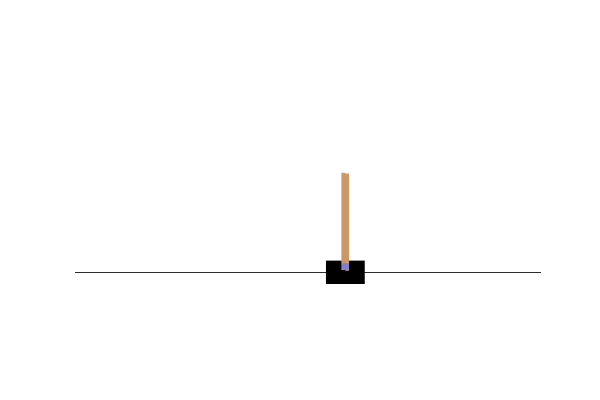
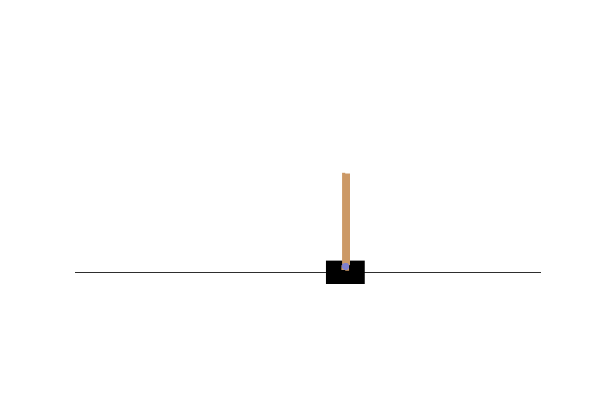
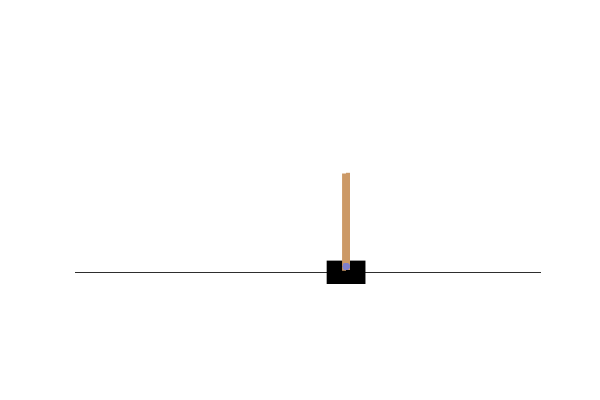
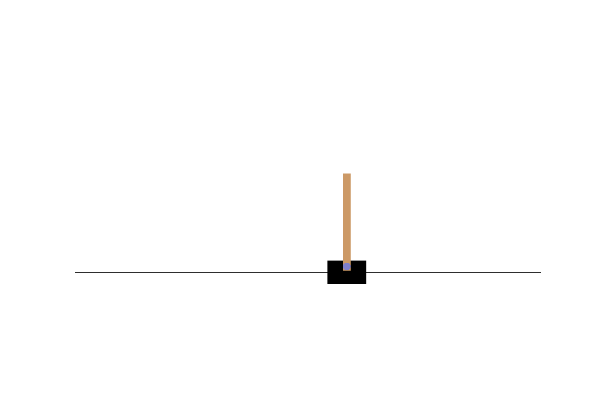
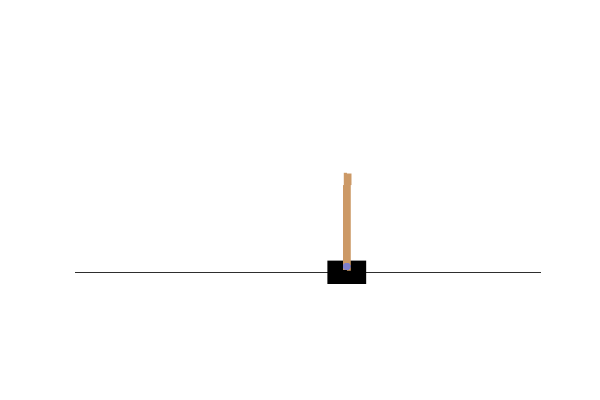
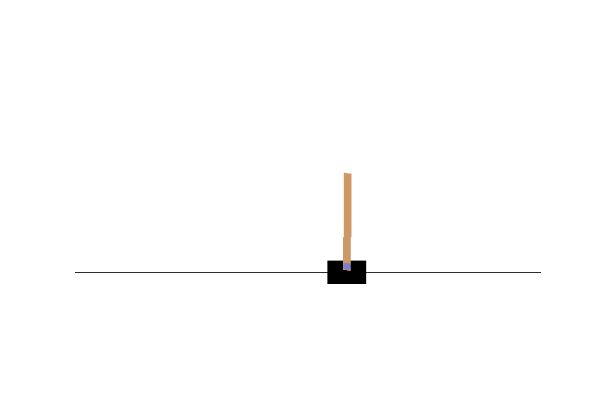
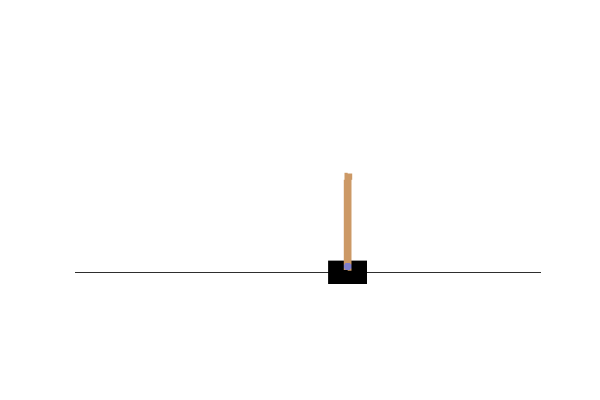
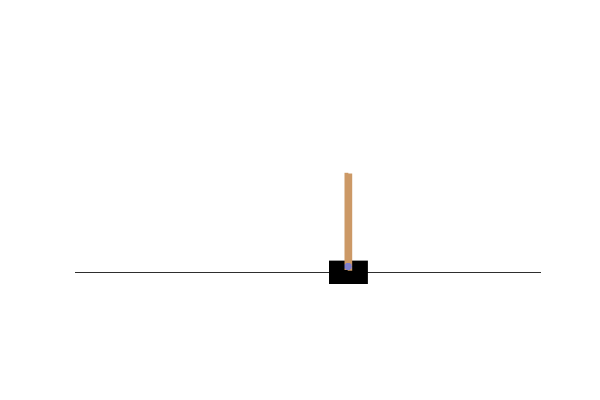
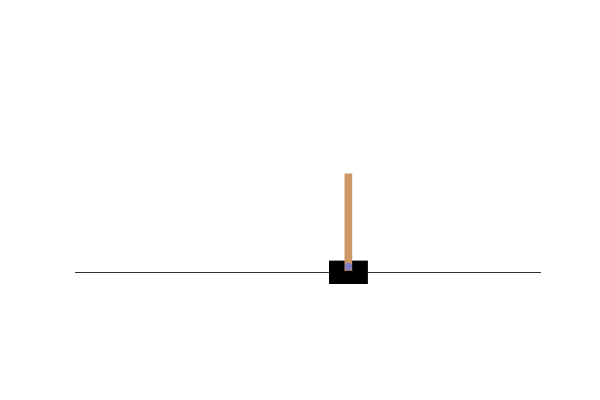
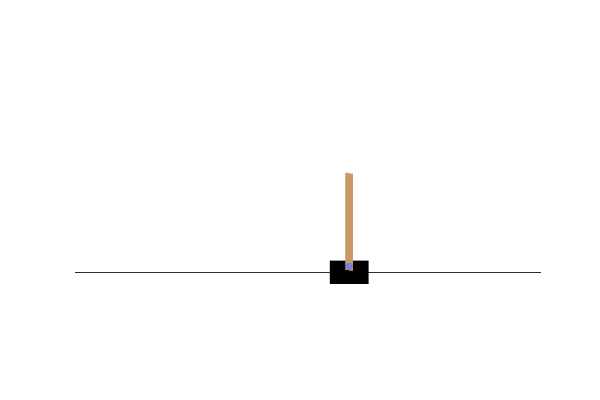
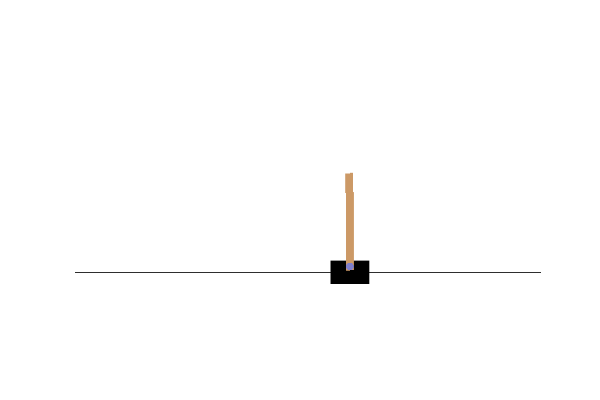
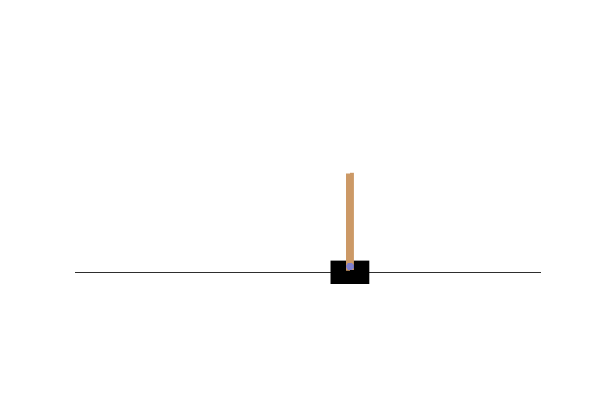
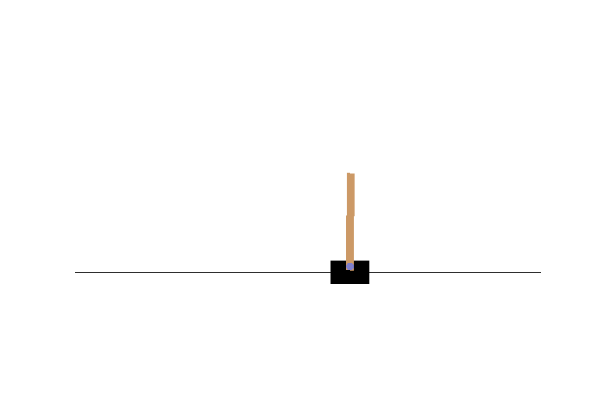
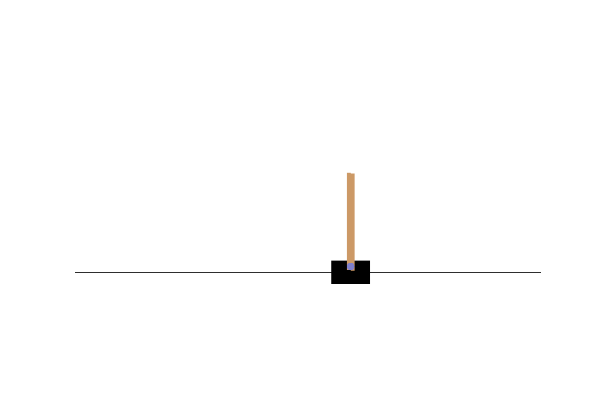
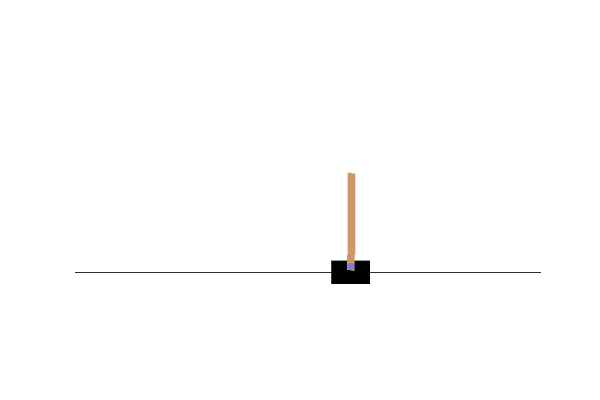
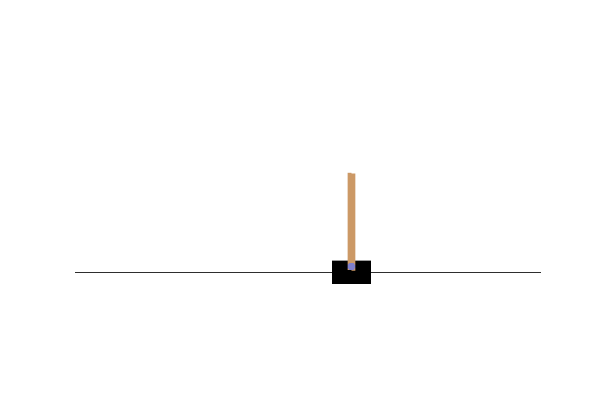
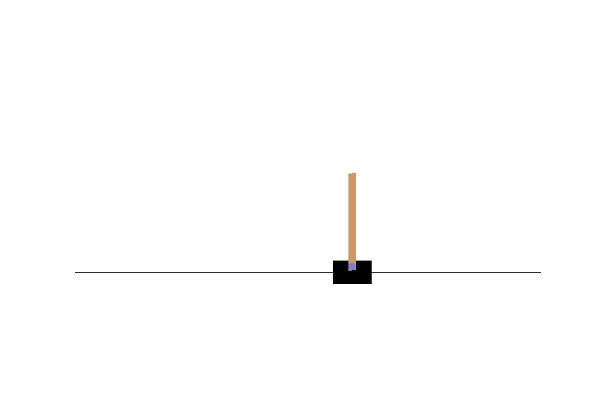
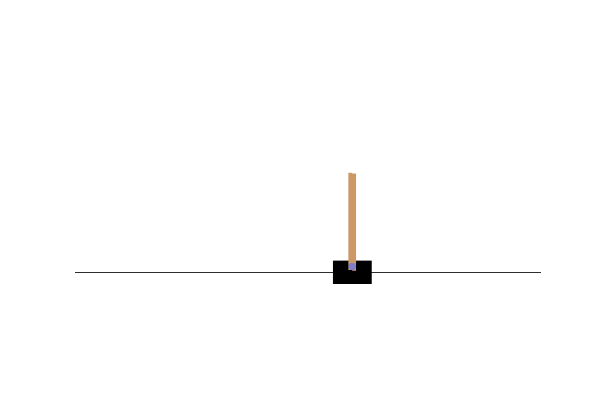
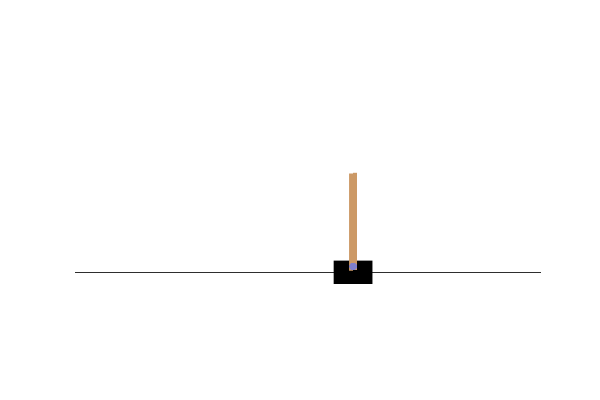
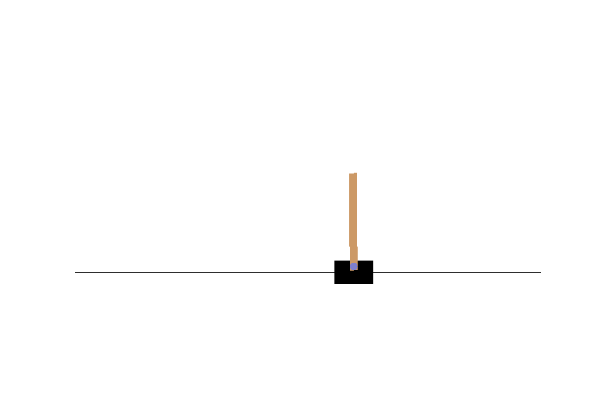
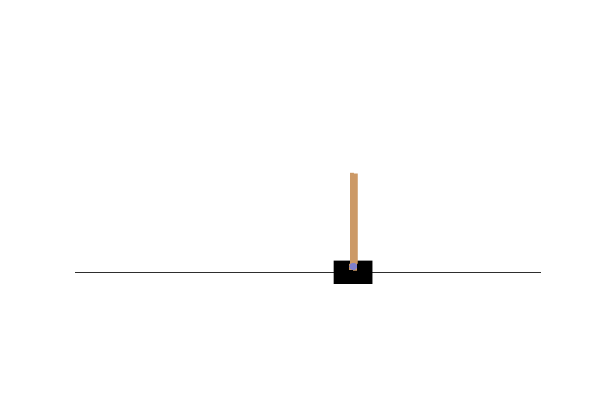
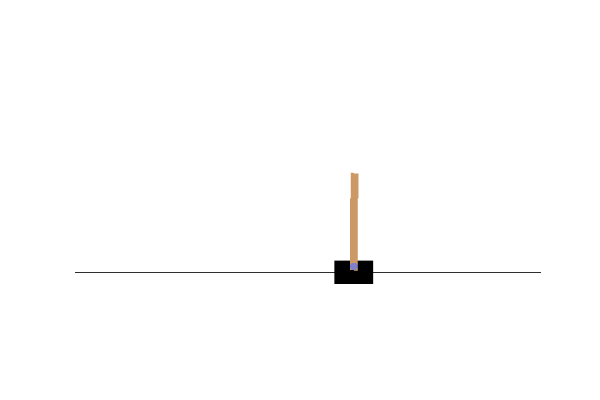
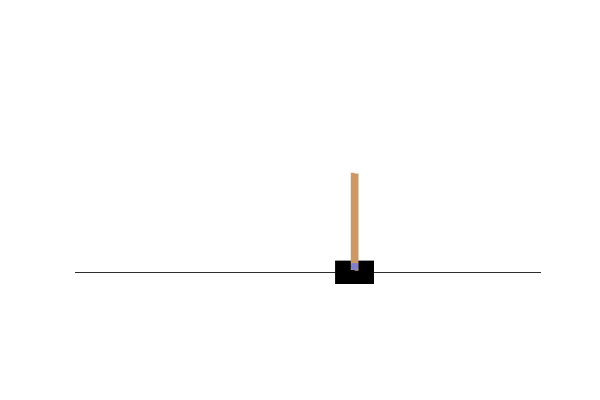
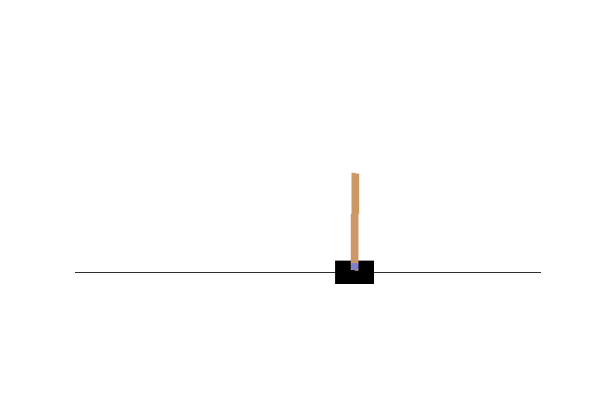
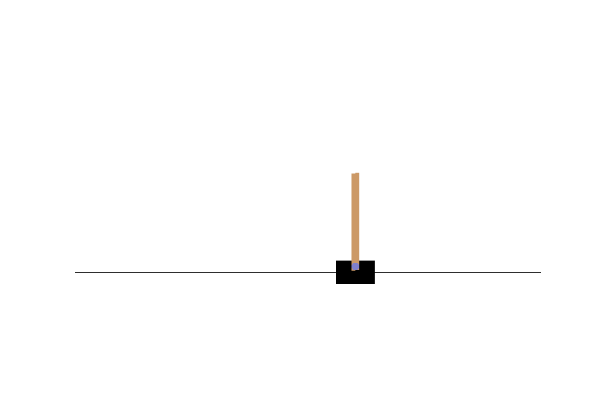
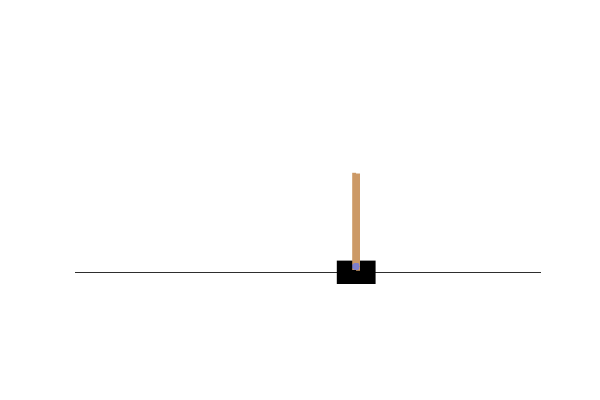
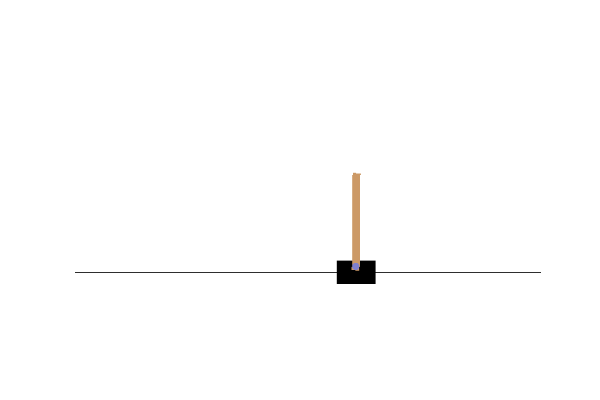
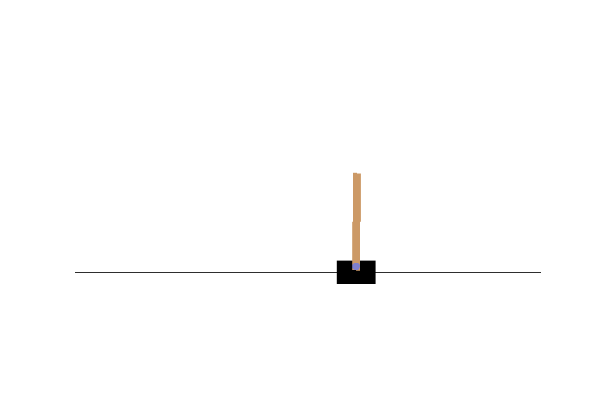
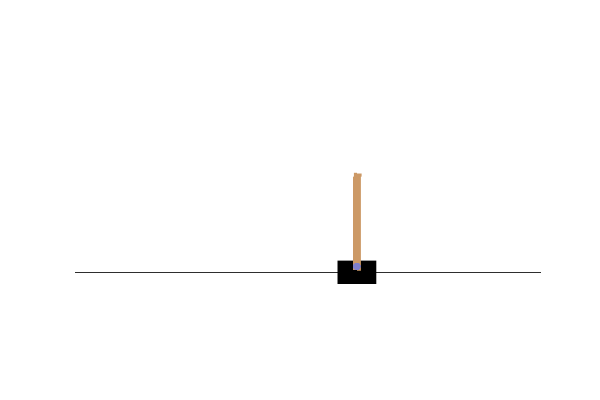
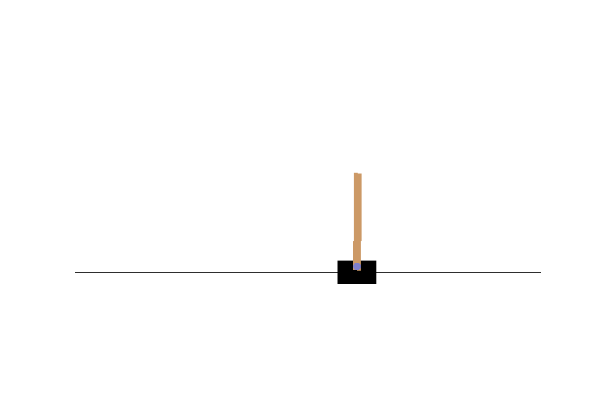
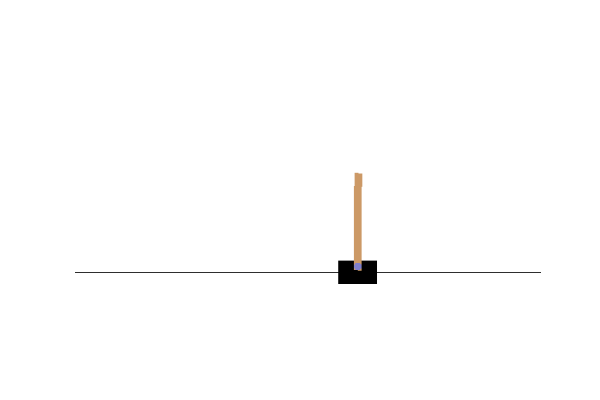
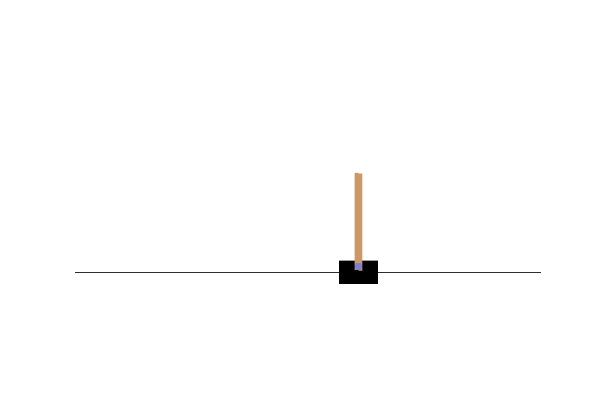
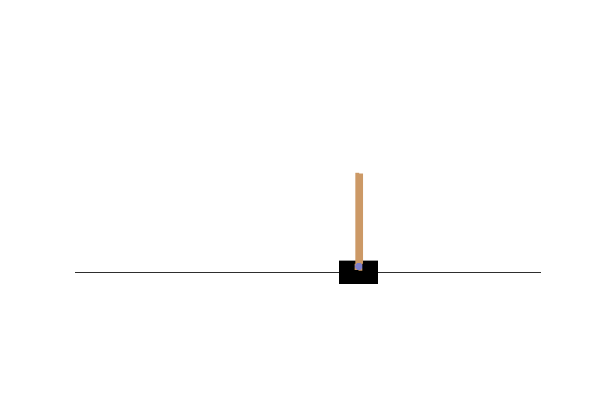
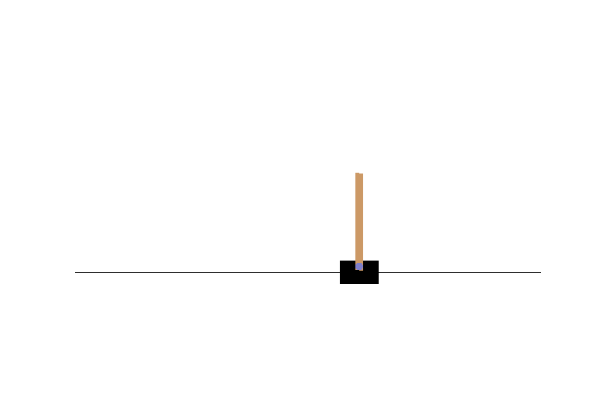
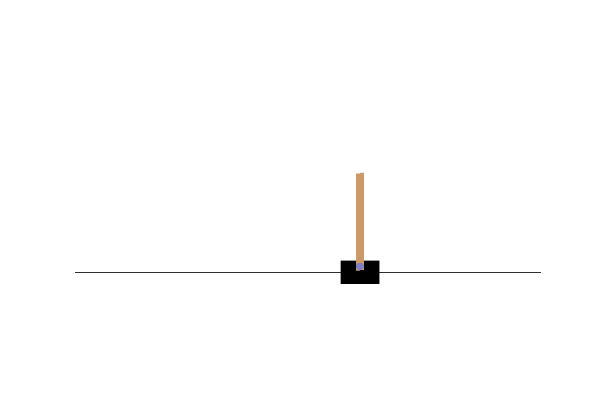
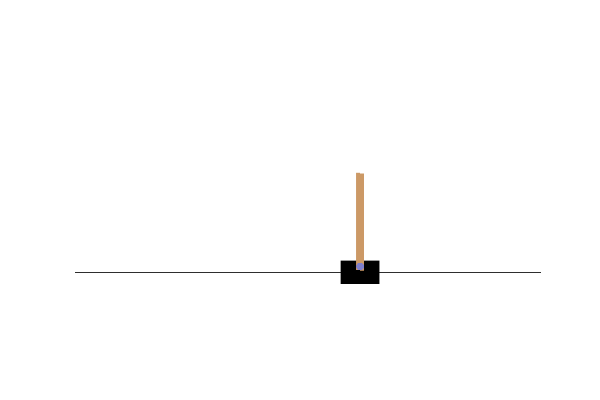
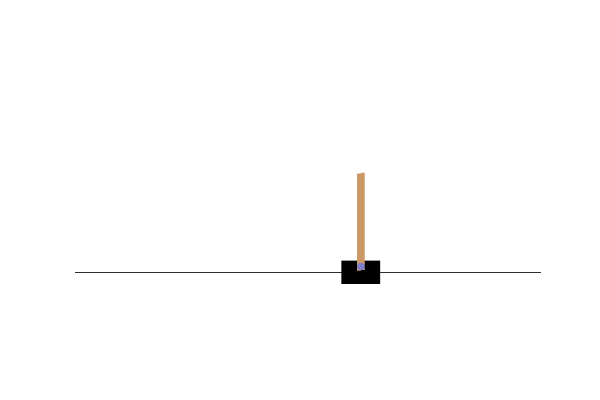
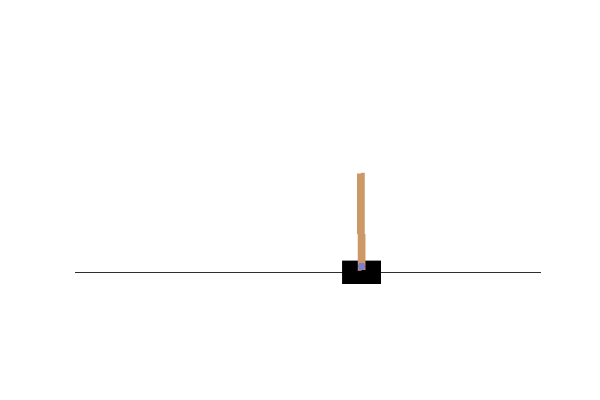
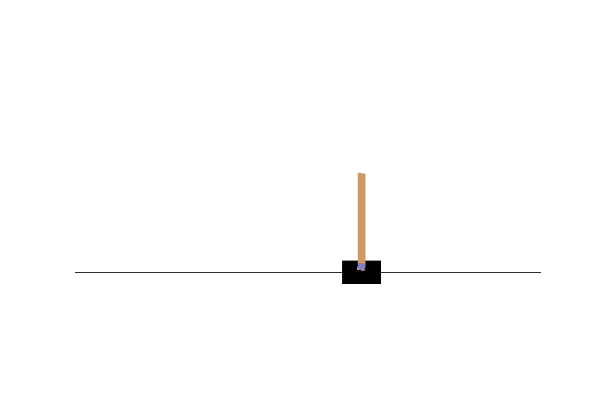
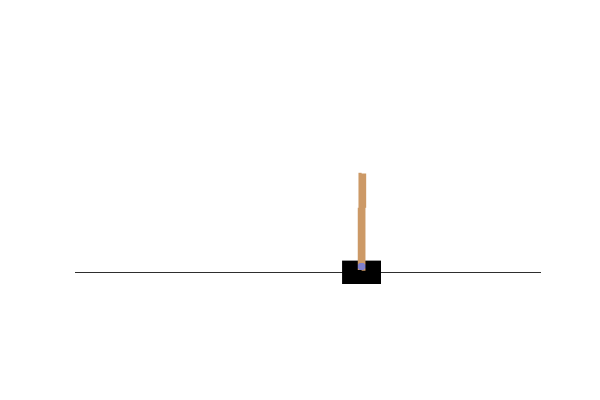
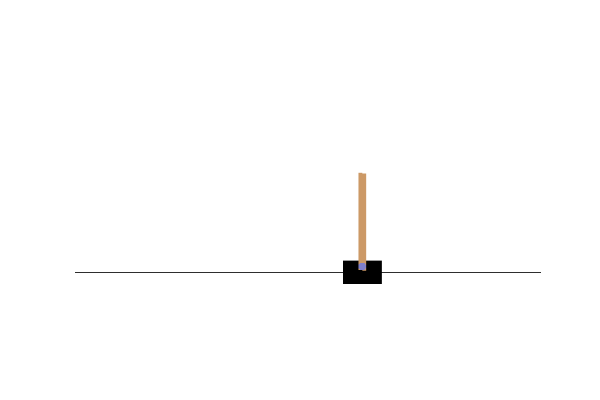
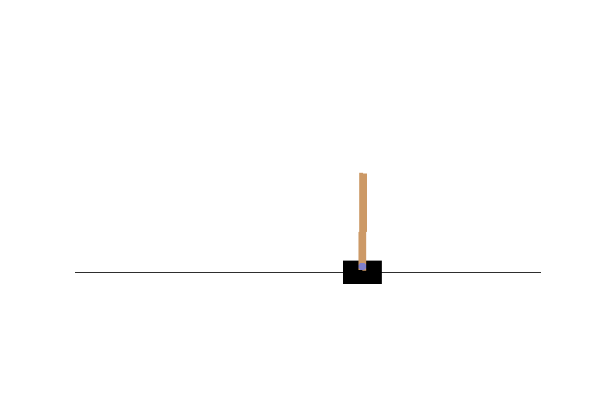
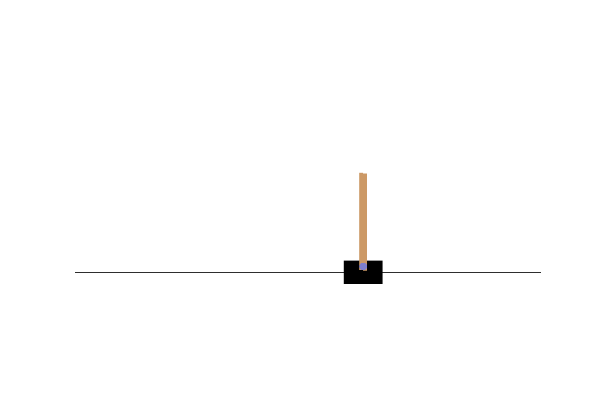
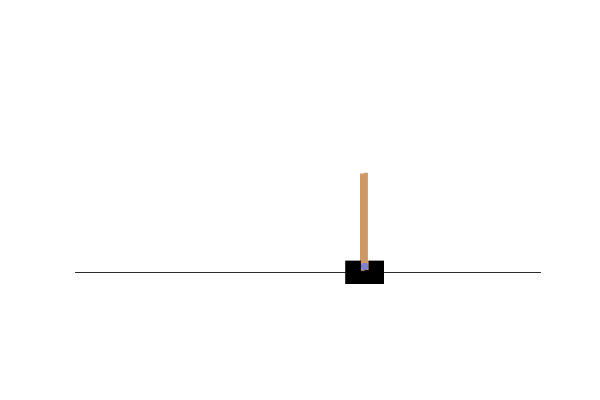
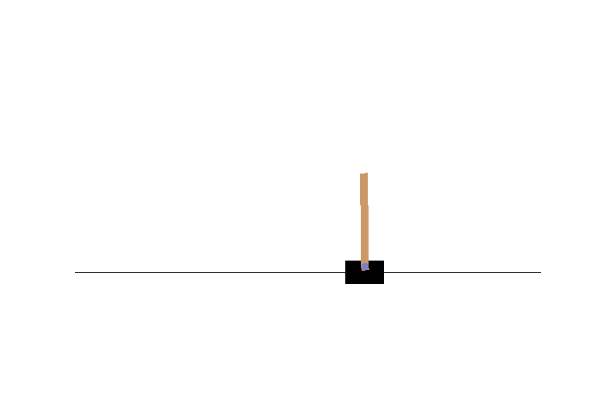
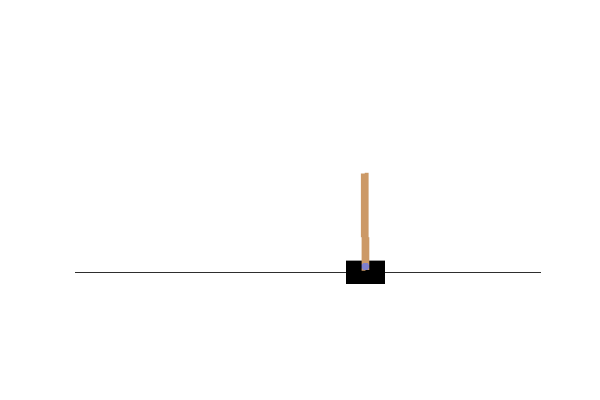
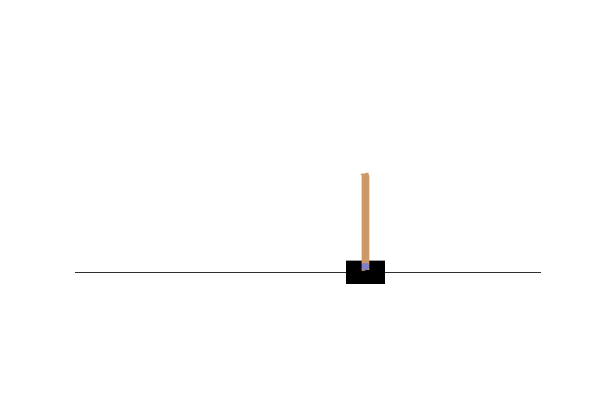
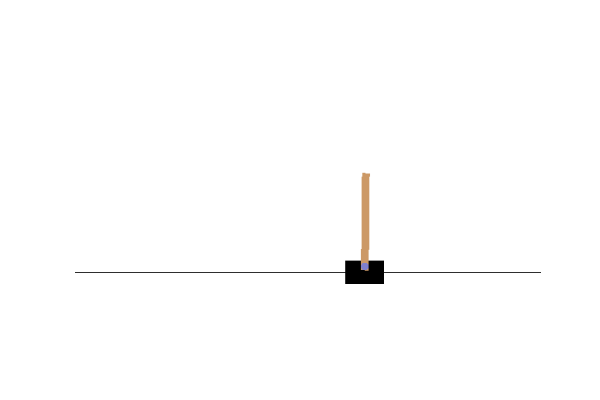
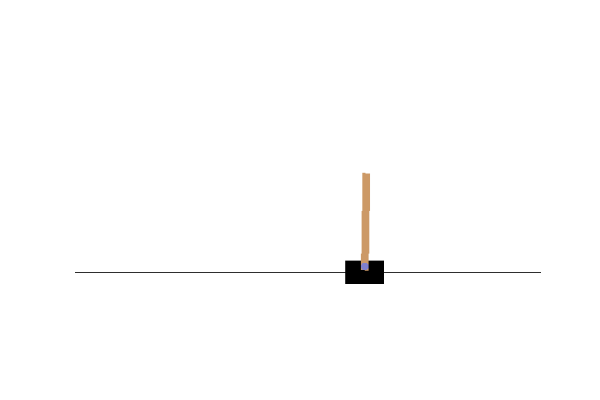
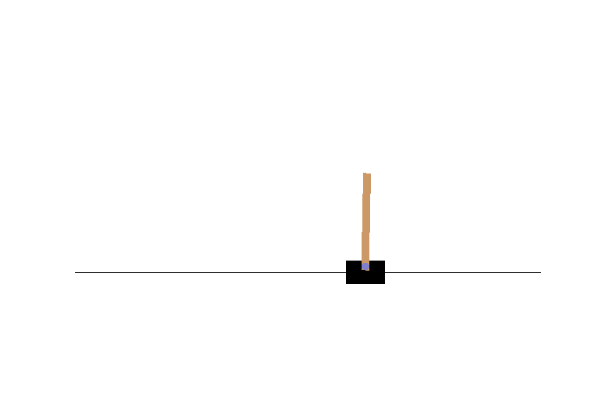
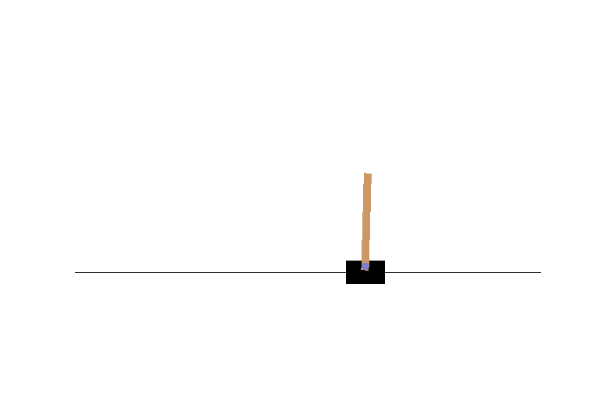
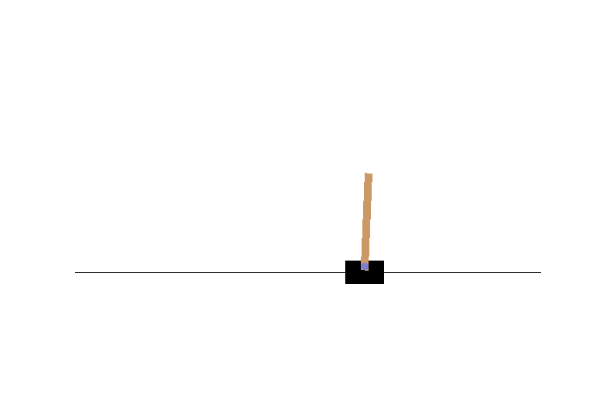
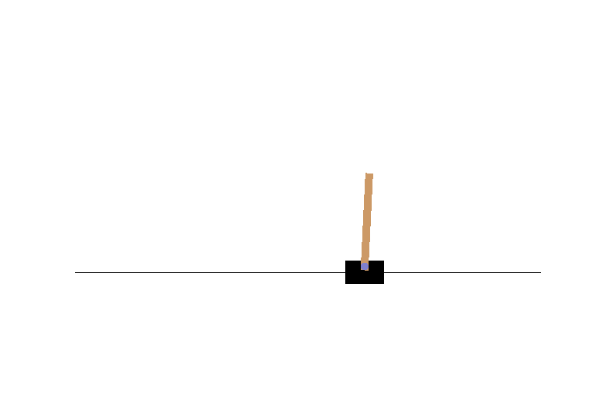
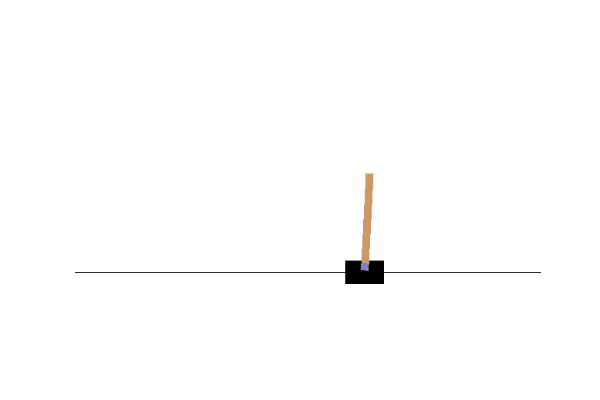
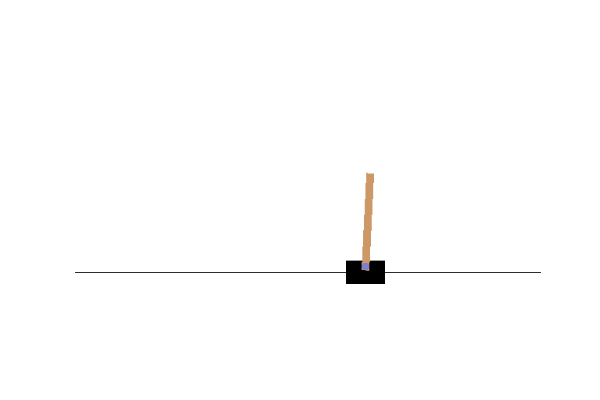
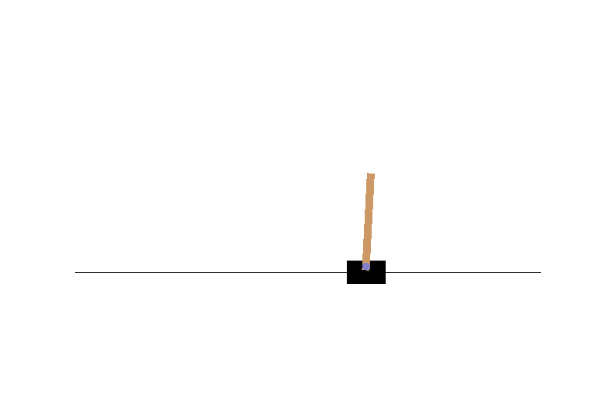
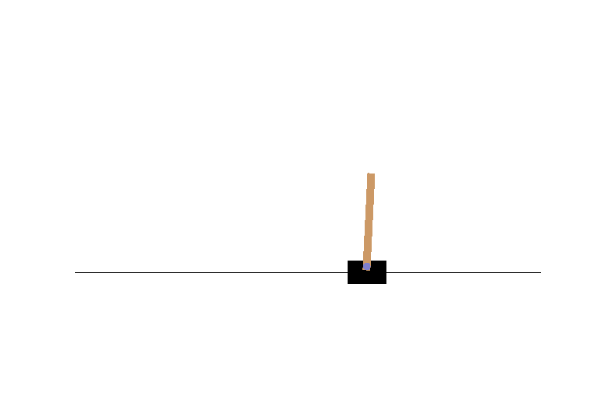
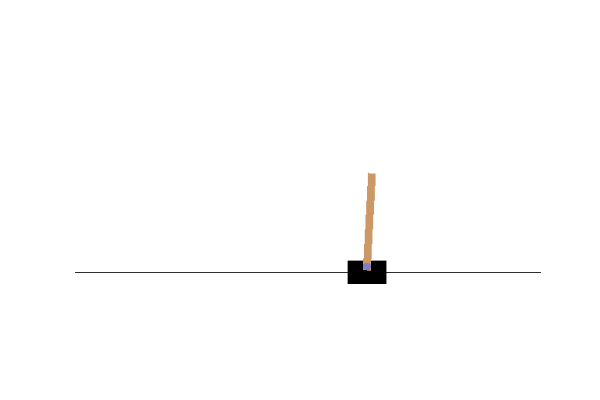
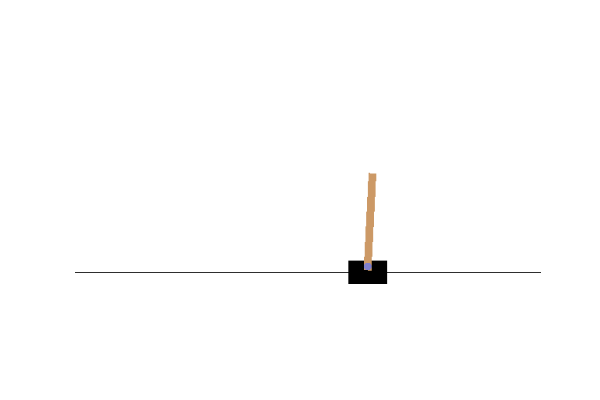
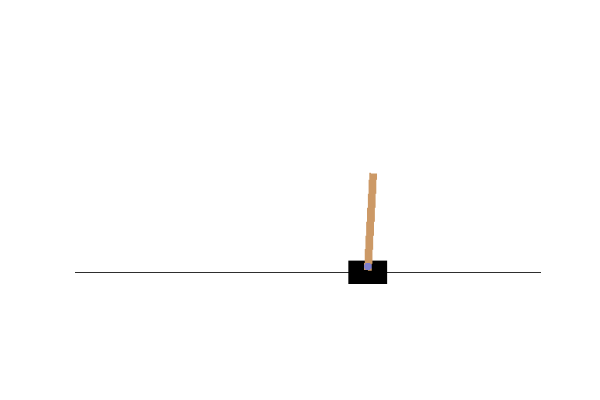
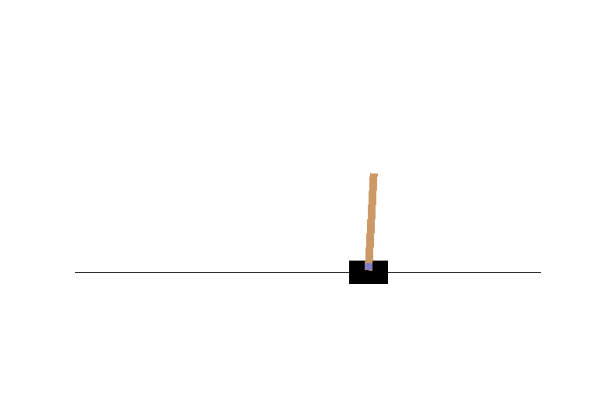
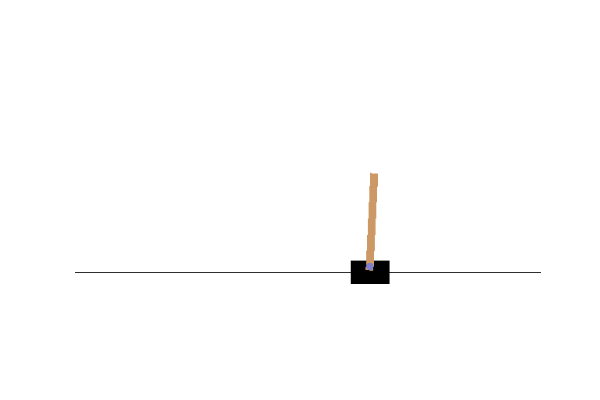
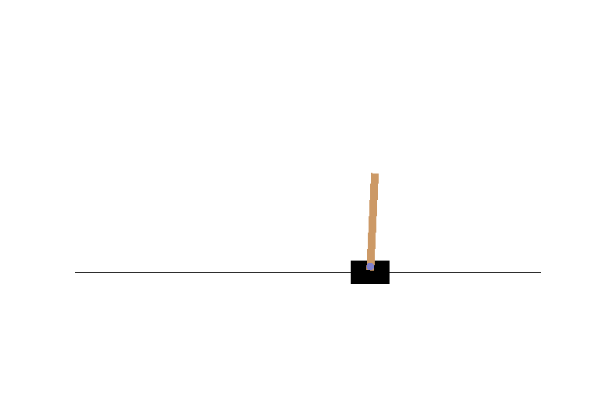
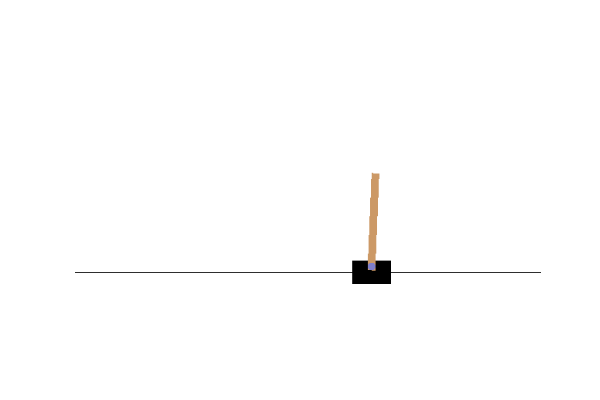
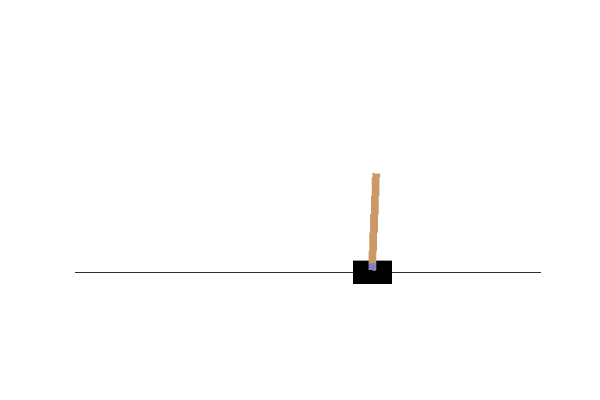
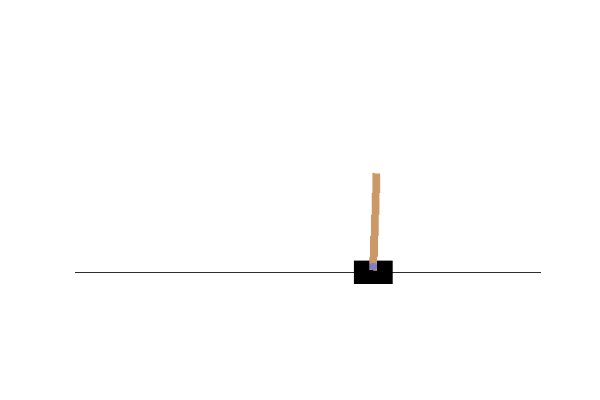
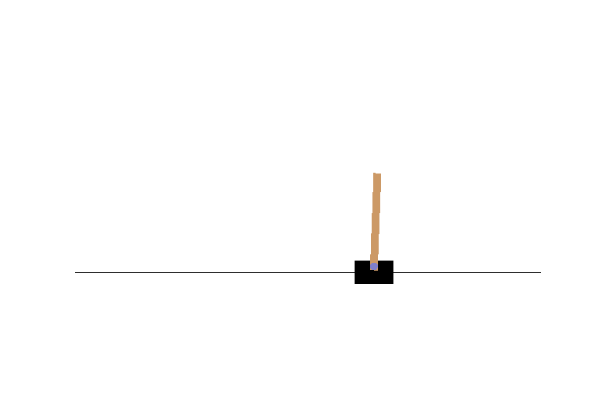
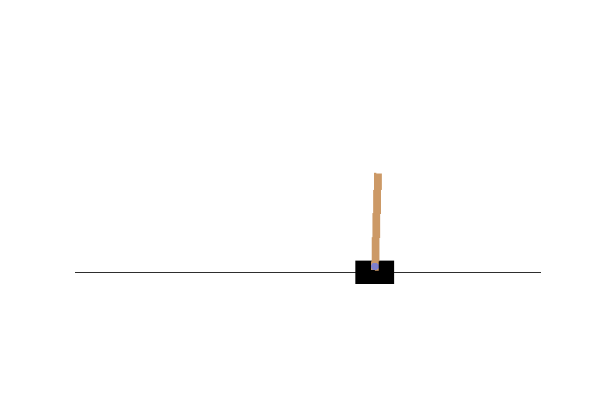
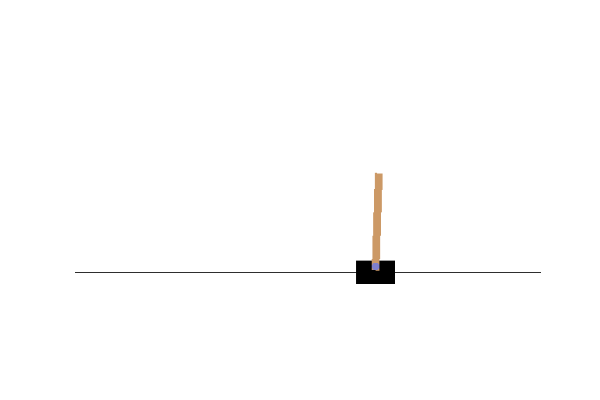
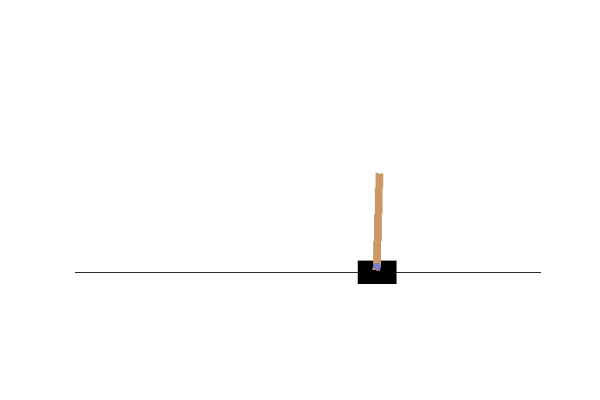
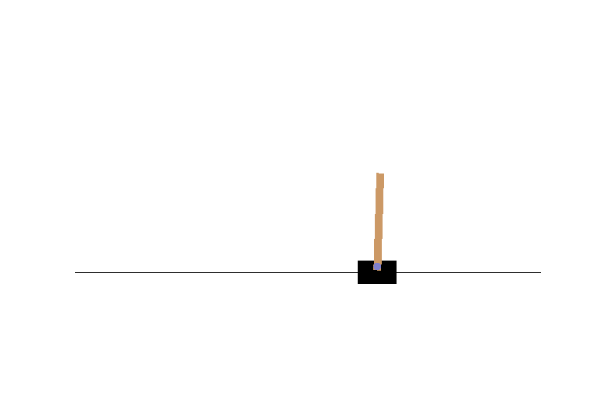
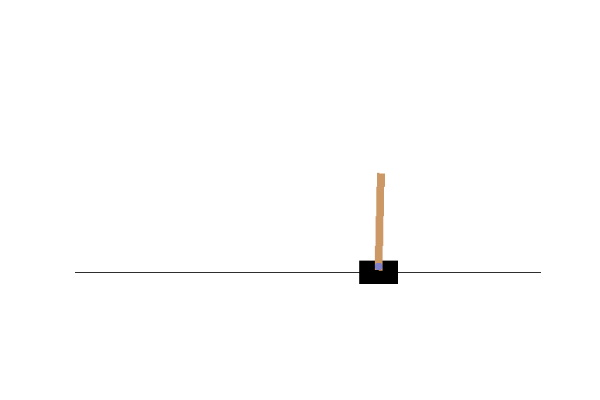
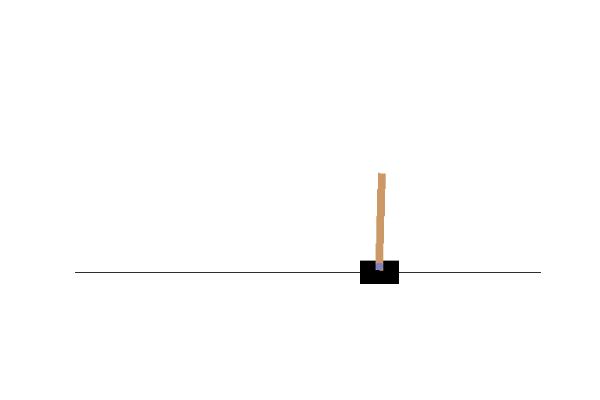
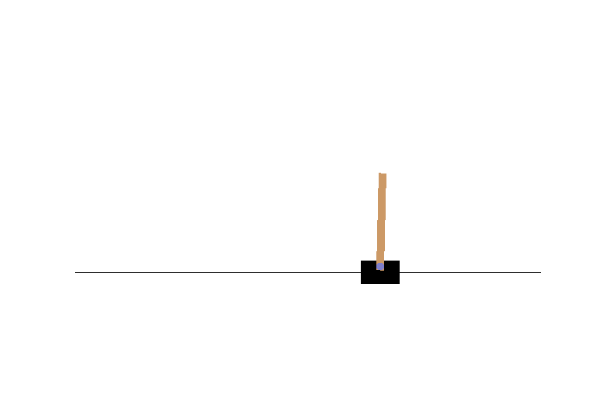

In [0]:
experiment_name = 'qlearning' # @param
policy_version = 800 # @param

# Round down to the last saved policy version.
policy_version = int(policy_version/POLICY_SAVE_FREQUENCY) * POLICY_SAVE_FREQUENCY

render_env = gym.make('CartPole-v0')

try:
  with sess.as_default():
    qnet.set_params(policy_params[experiment_name][policy_version])
    frames = []
    collect_episode(render_env, qnet, frames=frames)
    display_frames_as_gif(frames)
except e:
  print ('DISPLAY ERROR: Cannot render episodes unless colab kernel was '
         'manually run from corp machine.')
  raise e
  
del render_env